In [1]:
import numpy as np
import pandas as pd

import os

from duncan_test import duncan_test

import ipywidgets as widgets

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

import matplotlib.gridspec as gridspec

In [2]:
def drop_zero_cols(df):
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    df.replace(" ", 0, inplace=True)
    df = df.loc[:, (df != 0).any(axis=0)] # Drop columns with all zero values
    return df

#function to compute richness of a community 
def richness(list):

    are_all_numbers = all(isinstance(x, (int, float)) for x in list)

    assert are_all_numbers, "All elements in the list must be numbers"

    return np.count_nonzero( list )

#function to compute Shannon's diversity index 
def shannon_idx(list):
    
    #assert 0 not in list, "All elements in the list must be non-zero!"
    idx = 0
    for l in list:
        if l != 0:
            idx += -l*np.log(l) 
    #assert sum(list) == 1, "Elements of the list must sum to 1!"
    return idx

In [3]:
#df = pd.read_excel("C:/Users/edoardo.marchi/Dropbox/microbiome/SoilHealth-Fungi_mod.xlsx", skiprows=3) 
df = pd.read_excel("C:/Users/edo13/Dropbox/microbiome/SoilHealth-Fungi_mod.xlsx", skiprows=3) 

In [4]:
# keeping only abiotic data

#df_ab = df[["TREAT", "Season", "S.M", "OM", "EC-(ds/m)", "pH", 'TN-(%)', 'OC-(%)', 'C:N']]

df_ab = df[["SITE", "TREAT", "Season", "S.M", "OM", "EC-(ds/m)", "pH", 'TN-(%)', 'OC-(%)', 'C:N',
 'Ascomycota', 
 'Basidiomycota',
 'Chytridiomycota',
 'Glomeromycota',
 'Mortierellomycota',
 'Mucoromycota',
 'Rozellomycota',
 'uni']]

# creating a list of phyla 
# discard Kickxellomycota since they're extremely rare 

phyla_list = [ 'Ascomycota', 
 'Mortierellomycota',
 'uni',
 'Basidiomycota',
 'Chytridiomycota',
 'Glomeromycota',
 'Mucoromycota',
 'Rozellomycota'
 ] 

#creating a list of abiotic

abiotic = ["S.M", "OM", "EC-(ds/m)", 'pH', 'TN-(%)', 'OC-(%)', 'C:N']

# standardize abiotics(subtract the average, divide by the std)
#for ab in abiotic:
#   df_ab[ab] = ( df_ab[ab]-df_ab[ab].mean() )/df_ab[ab].std()

In [5]:
# compute normalization
norm=df_ab[phyla_list].sum(axis=1, numeric_only=True)

In [6]:
# keep only non-zero rows
df_ab=df_ab.iloc[norm[norm.values>0.].index]
norm=norm[norm.values>0.]

#df_ab = df_ab.reset_index(drop=True)

# rescale phyla values to [0, 1]

for phyla in phyla_list:
    df_ab[phyla] = df_ab[phyla]/norm

In [7]:
# dataset where we replace nan with zeros. In some cases we need to use this. 

df_ab_mod = df_ab.fillna(0.)

df_ab_mod = df_ab_mod.replace(" ", 0)

# PHYLA ABUNDANCES STACKPLOT

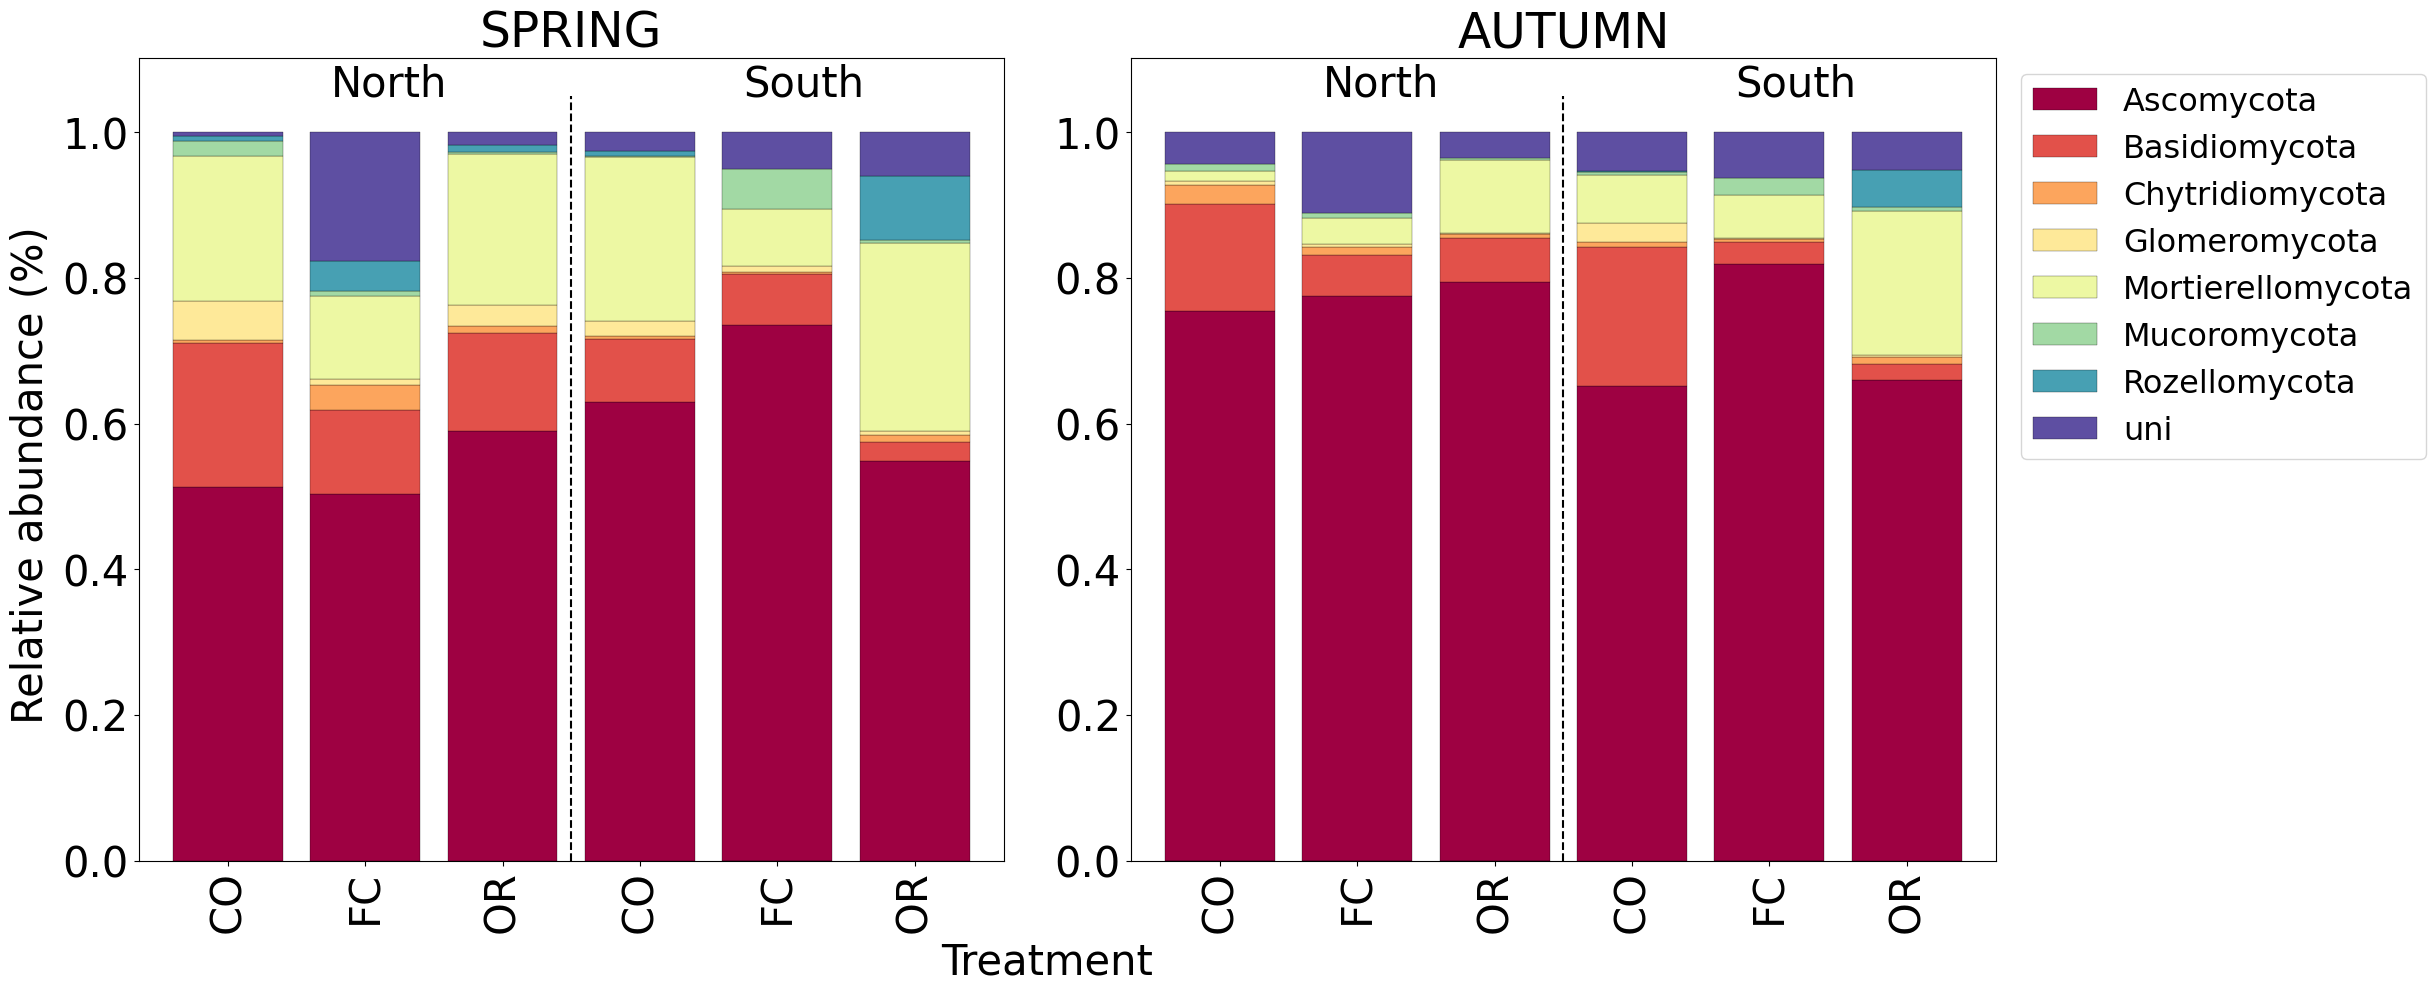

In [8]:
# AUT vs SPR, averaged over all the other factors

fig, ax = plt.subplots( 1, 2, figsize = ( 2*10, 10 ) )

# dropping also Olpidiomycota here, to few non-zero entries
df_group = df_ab[["SITE",
                  "TREAT", 
                  "Season",
                  'Ascomycota', 
                  'Basidiomycota',
                  'Chytridiomycota',
                  'Glomeromycota',
                  'Mortierellomycota',
                  'Mucoromycota',
                  'Rozellomycota',
                  'uni']]

df_group = df_group.groupby(["Season", "SITE", "TREAT"]).mean()

col = sns.color_palette("hls", 11)

df_group.loc["SPR"].plot(kind='bar', stacked=True,
                         ax = ax[0], width=0.8,
                         edgecolor="black", lw=0.2,
                         legend = False, colormap = 'Spectral')

ax[0].set_xlabel("Treatment", fontsize = 30)
ax[0].set_ylabel("Relative abundance (%)", fontsize = 30)
ax[0].plot([2.5,2.5], [0,1.05], 'k--')
ax[0].text(0.75, 1.05, "North", fontsize = 30)
ax[0].text(0.75+3, 1.05, "South", fontsize = 30)
ax[0].set_title("SPRING", fontsize = 35)
ax[0].set_xticklabels(2*["CO", "FC", "OR"])
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].xaxis.set_label_coords(1.05, -0.1)
ax[0].yaxis.set_label_coords(-0.1, 0.48)

df_group.loc["AUT"].plot(kind='bar', stacked=True,
                         ax = ax[1], width=0.8,
                         edgecolor="black", lw=0.2,
                         legend = True, colormap = 'Spectral')

ax[1].set_xlabel("", fontsize = 25)
#ax[1].set_ylabel("Relative abundance (%)", fontsize = 25)
ax[1].plot([2.5,2.5], [0,1.05], 'k--')
ax[1].text(0.75, 1.05, "North", fontsize = 30)
ax[1].text(0.75+3, 1.05, "South", fontsize = 30)
ax[1].set_title("AUTUMN", fontsize = 35)
ax[1].set_xticklabels(2*["CO", "FC", "OR"])
ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].xaxis.set_label_coords(0.5, -0.2)
ax[1].yaxis.set_label_coords(-0.1, 0.5)

fig.tight_layout()

ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize = 23)
#ax.set_ylim([0, 1])

#plt.savefig("stacked_plots/stacked_complete.pdf", bbox_inches = 'tight')

In [9]:
# prepare dataframe with genera abundances

# drop last columns, then keep only first 4 columns and all the genera columns
df_genera = df.iloc[:, :-5]
df_genera_1 = df_genera[['SITE', 'Season','TREAT']]
df_genera_2 = df_genera.iloc[:, 25:]
df_genera = pd.concat( [df_genera_1, df_genera_2], axis=1 )

In [10]:
norm=df_genera.iloc[:, 3:].sum(axis=1, numeric_only=True)

# remove zero rows
df_genera=df_genera.iloc[norm[norm.values>0.].index]
df_genera = drop_zero_cols(df_genera)

norm=norm[norm.values>0.]

for col in df_genera.columns[3:]:
    df_genera[col]=df_genera[col]/norm  

# we replace nan with zeros

df_genera = df_genera.fillna(0.)

df_genera = df_genera.replace(" ", 0)    

In [11]:
df_genera.insert(3, "Shannon_Index_genera", np.zeros(len(df_genera)), True)
df_genera.insert(3, "Richness_genera", np.zeros(len(df_genera)), True)
df_genera = df_genera.reset_index(drop=True)

In [12]:
for i in range(len(df_genera)):
    df_genera.at[i, "Shannon_Index_genera"] = shannon_idx( df_genera.iloc[i, 3:]) 
    df_genera.at[i, "Richness_genera"] = richness( df_genera.iloc[i, 3:]) 

In [13]:
df_ab_mod.insert(3, "Shannon_Index", np.zeros(len(df_ab_mod)), True)
df_ab_mod.insert(3, "Richness", np.zeros(len(df_ab_mod)), True)

df_ab_mod = df_ab_mod.reset_index(drop=True)

In [14]:
for i in range(len(df_ab)):
    df_ab_mod.at[i, "Shannon_Index"] = shannon_idx( df_ab_mod.iloc[i, 12:]) 
    df_ab_mod.at[i, "Richness"] = richness( df_ab_mod.iloc[i, 12:]) 

In [15]:
def annotate_duncan_test(result, means):

    co_fc = result["FC"][0]
    co_or = result["OR"][0]
    fc_or = result["OR"][1]
    results = [co_fc, co_or, fc_or]
    annot = ["", "", ""]

    if np.count_nonzero(results) == 1:
        
        if co_fc:
            if means["CO"] < means["FC"]:
                annot = ["a", "b", ""]
            else:
                annot = ["b", "a", ""]   
        elif co_or:
            if means["CO"] < means["OR"]:
                annot = ["a", "", "b"]  
            else:
                annot = ["b", "", "a"]
        else: 
            if means["FC"] < means["OR"]:
                annot = ["", "a", "b"]
            else:
                annot = ["", "b", "a"]  

    elif np.count_nonzero(results) == 2:
        if not co_fc:
            if means["FC"] < means["OR"]:
                annot = ["a", "a", "b"]    
            else:  
                annot = ["b", "b", "a"]   
        elif not co_or:
            if means["CO"] < means["FC"]:
                annot = ["a", "b", "a"]
            else:    
                annot = ["b", "a", "b"]
        else:
            if means["CO"] < means["FC"]:
                annot = ["a", "b", "b"] 
            else: 
                annot = ["b", "a", "a"]       

    elif np.count_nonzero(results) == 3:
        annot = ["a", "b", "c"]
        sorted_means = np.argsort(means)

        annot[sorted_means[0]] = "a"
        annot[sorted_means[1]] = "b"
        annot[sorted_means[2]] = "c"

    return annot

# RDA Table

In [16]:
# results from permanova test in R 

# Define the data as a dictionary
data = {
    "Factor": [
        "SITE", "TREAT", "Season", "S.M", "OM", 
        "EC-(ds/m)", "pH", "TN-(%)", "OC-(%)", "C:N", "Residual"
    ],
    "Df": [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 276],
    "Variance (%)": [
        13.370016, 63.245084, 86.204008, 20.511613, 7.709903, 
        3.701730, 4.187200, 6.529559, 5.220867, 3.330829, 956.283632
    ],
    "F": [
        3.8588178, 9.1268127, 24.8799680, 5.9200064, 2.2252115, 
        1.0683833, 1.2084984, 1.8845436, 1.5068324, 0.9613348, None
    ],
    "Pr(>F)": [
        0.023, 0.001, 0.001, 0.003, 0.086, 
        0.337, 0.276, 0.142, 0.190, 0.391, None
    ]
}

# Convert to a DataFrame
permanova_table = pd.DataFrame(data)

In [17]:
tot_var = 1170.3 # from rda in R 
permanova_table["Variance (%)"] = permanova_table["Variance (%)"]/tot_var 

In [18]:
permanova_table_latex = permanova_table.to_latex(escape=False)
print(permanova_table_latex)

\begin{tabular}{llrrrr}
\toprule
{} &     Factor &   Df &  Variance (%) &          F &  Pr(>F) \\
\midrule
0  &       SITE &    1 &      0.011424 &   3.858818 &   0.023 \\
1  &      TREAT &    2 &      0.054042 &   9.126813 &   0.001 \\
2  &     Season &    1 &      0.073660 &  24.879968 &   0.001 \\
3  &        S.M &    1 &      0.017527 &   5.920006 &   0.003 \\
4  &         OM &    1 &      0.006588 &   2.225211 &   0.086 \\
5  &  EC-(ds/m) &    1 &      0.003163 &   1.068383 &   0.337 \\
6  &         pH &    1 &      0.003578 &   1.208498 &   0.276 \\
7  &     TN-(%) &    1 &      0.005579 &   1.884544 &   0.142 \\
8  &     OC-(%) &    1 &      0.004461 &   1.506832 &   0.190 \\
9  &        C:N &    1 &      0.002846 &   0.961335 &   0.391 \\
10 &   Residual &  276 &      0.817127 &        NaN &     NaN \\
\bottomrule
\end{tabular}



C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\293227030.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  permanova_table_latex = permanova_table.to_latex(escape=False)


# PHYLA ABUNDANCES ARE WEAKLY DEPENDENT ON SITE ...

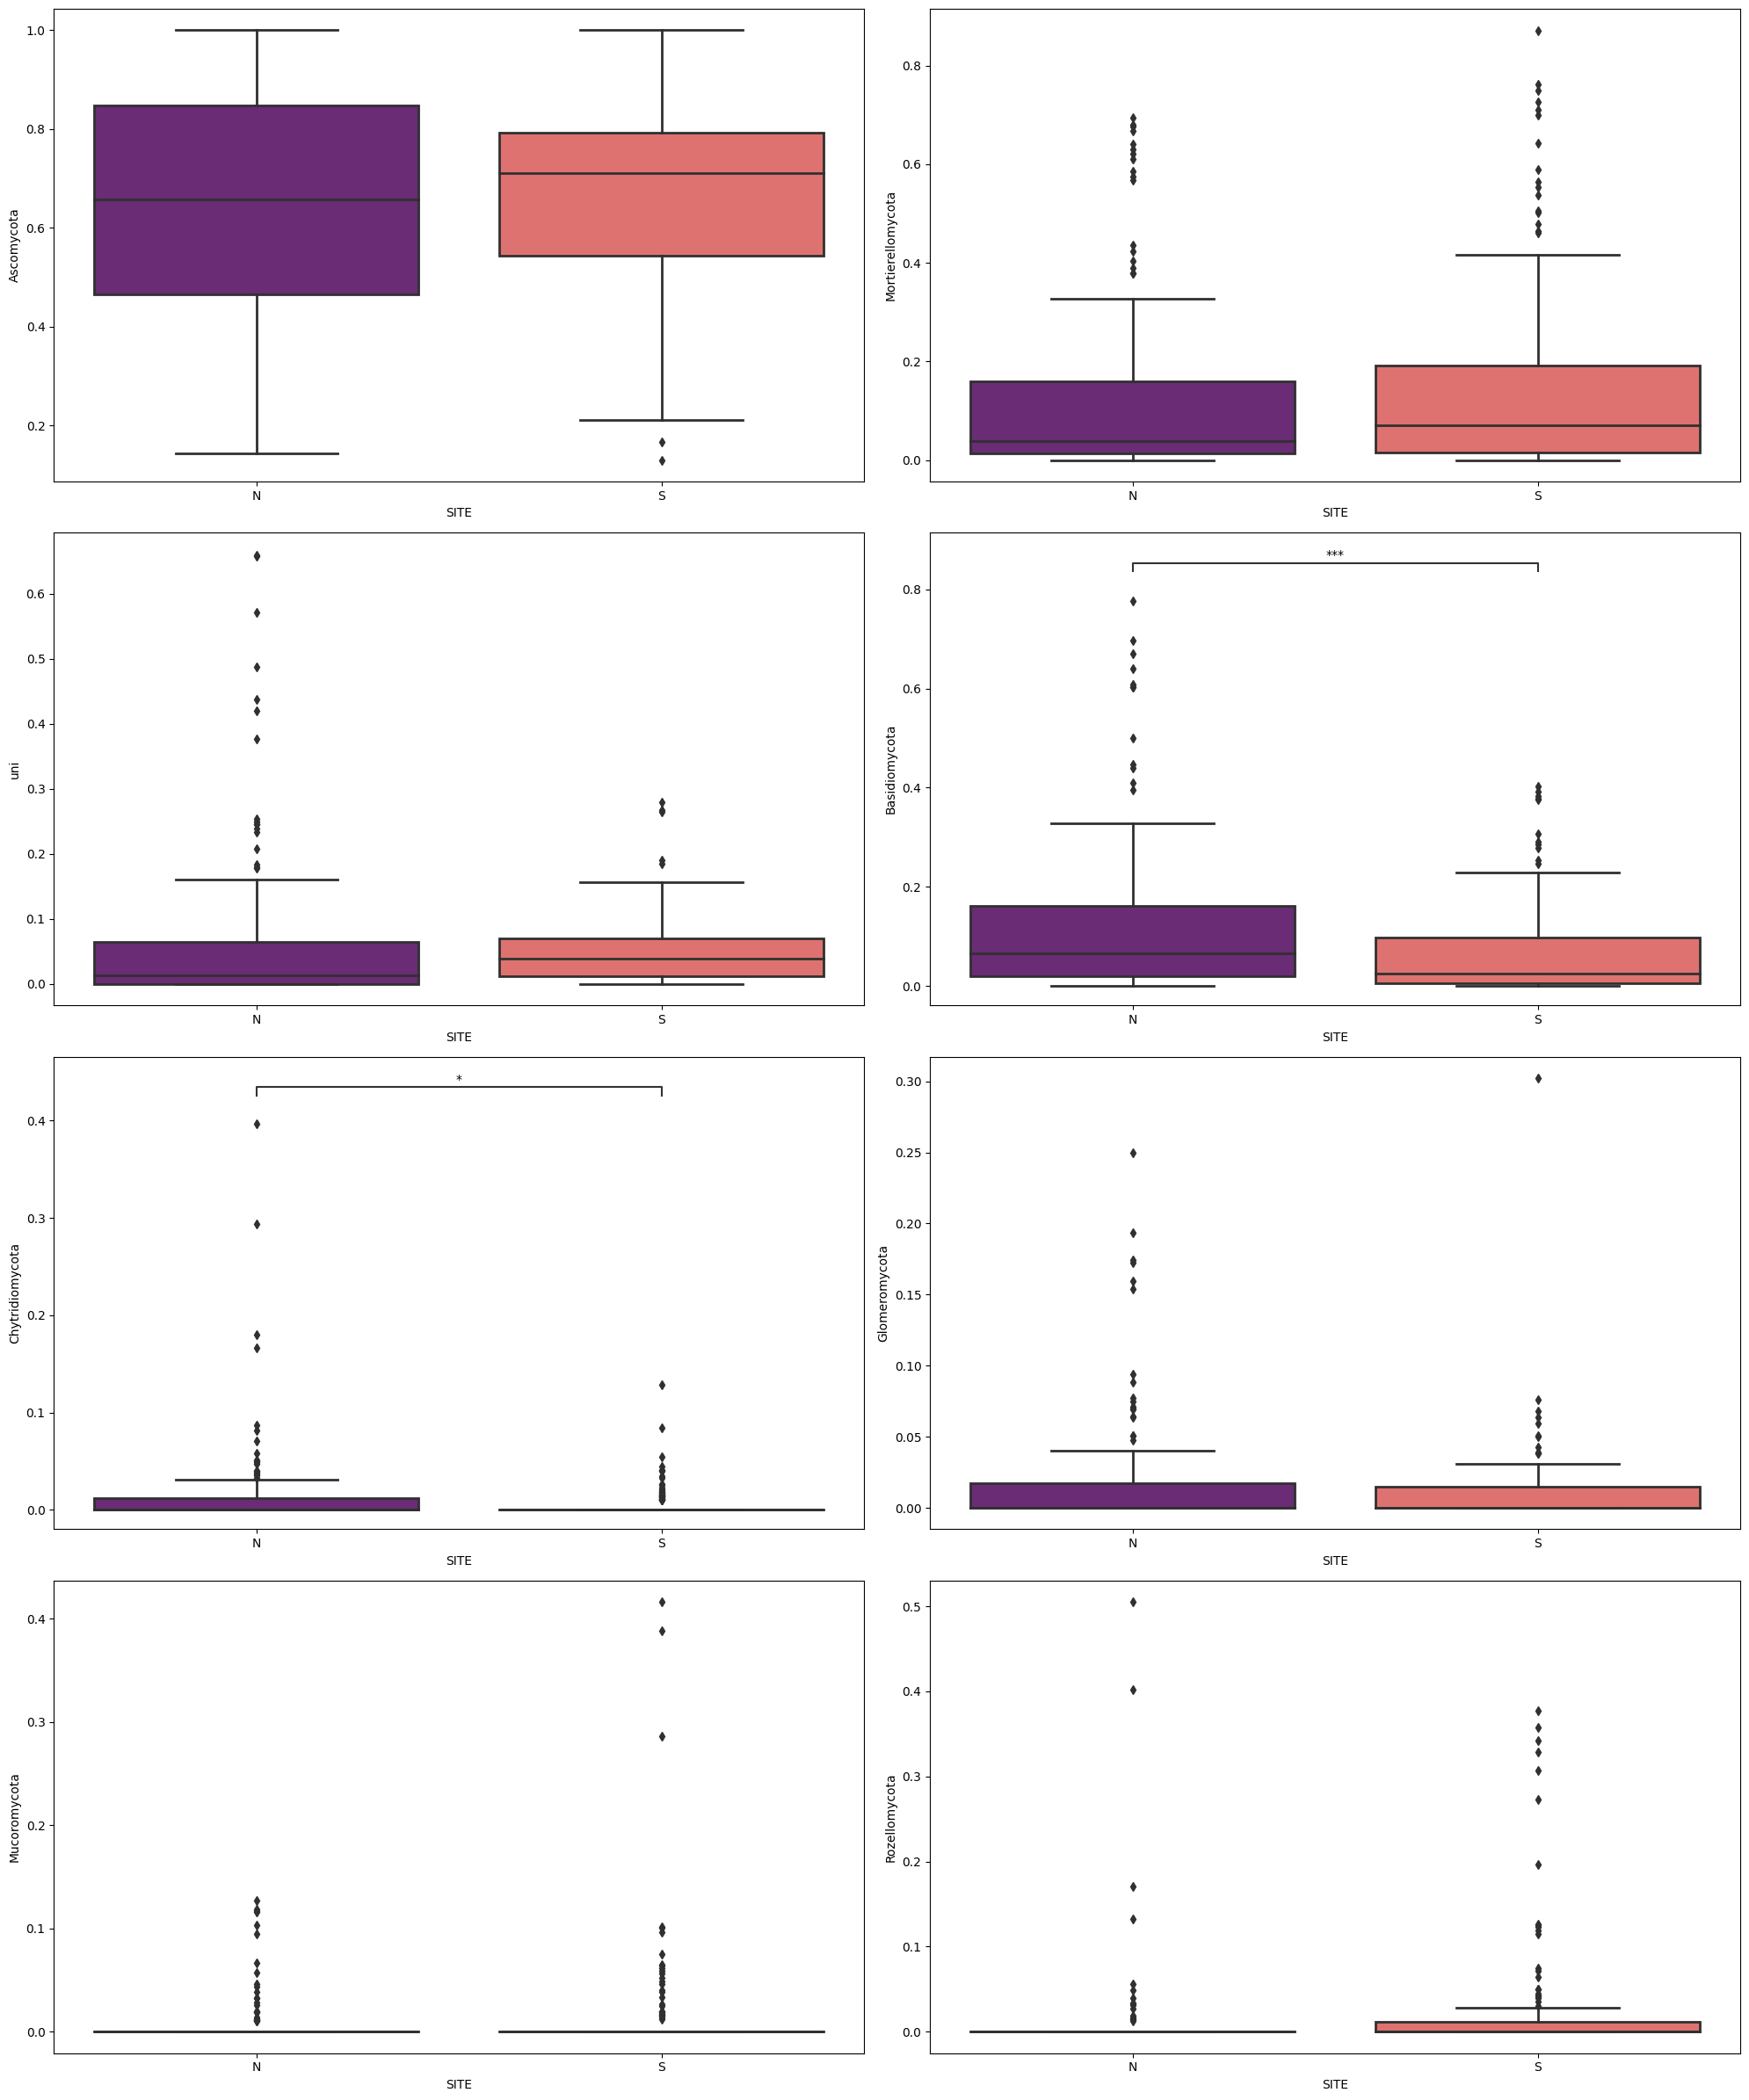

In [19]:
fig, axx = plt.subplots(4, 2, figsize=(2*10, 4*6), tight_layout=True)
axx = axx.reshape(-1)

pairs = [("N", "S")]

for ax, node in zip(axx, phyla_list):

    plotting_parameters = {
        'data':    df_ab,
        'x':       'SITE',
        'y':       node
    }
    
    ax = sns.boxplot(**plotting_parameters, ax=ax, palette = "magma", linewidth=2)     

    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

plt.savefig("comparison_sites.pdf", bbox_inches = 'tight')    

## but if we compare without averaging over the seasons, the differences are not so small

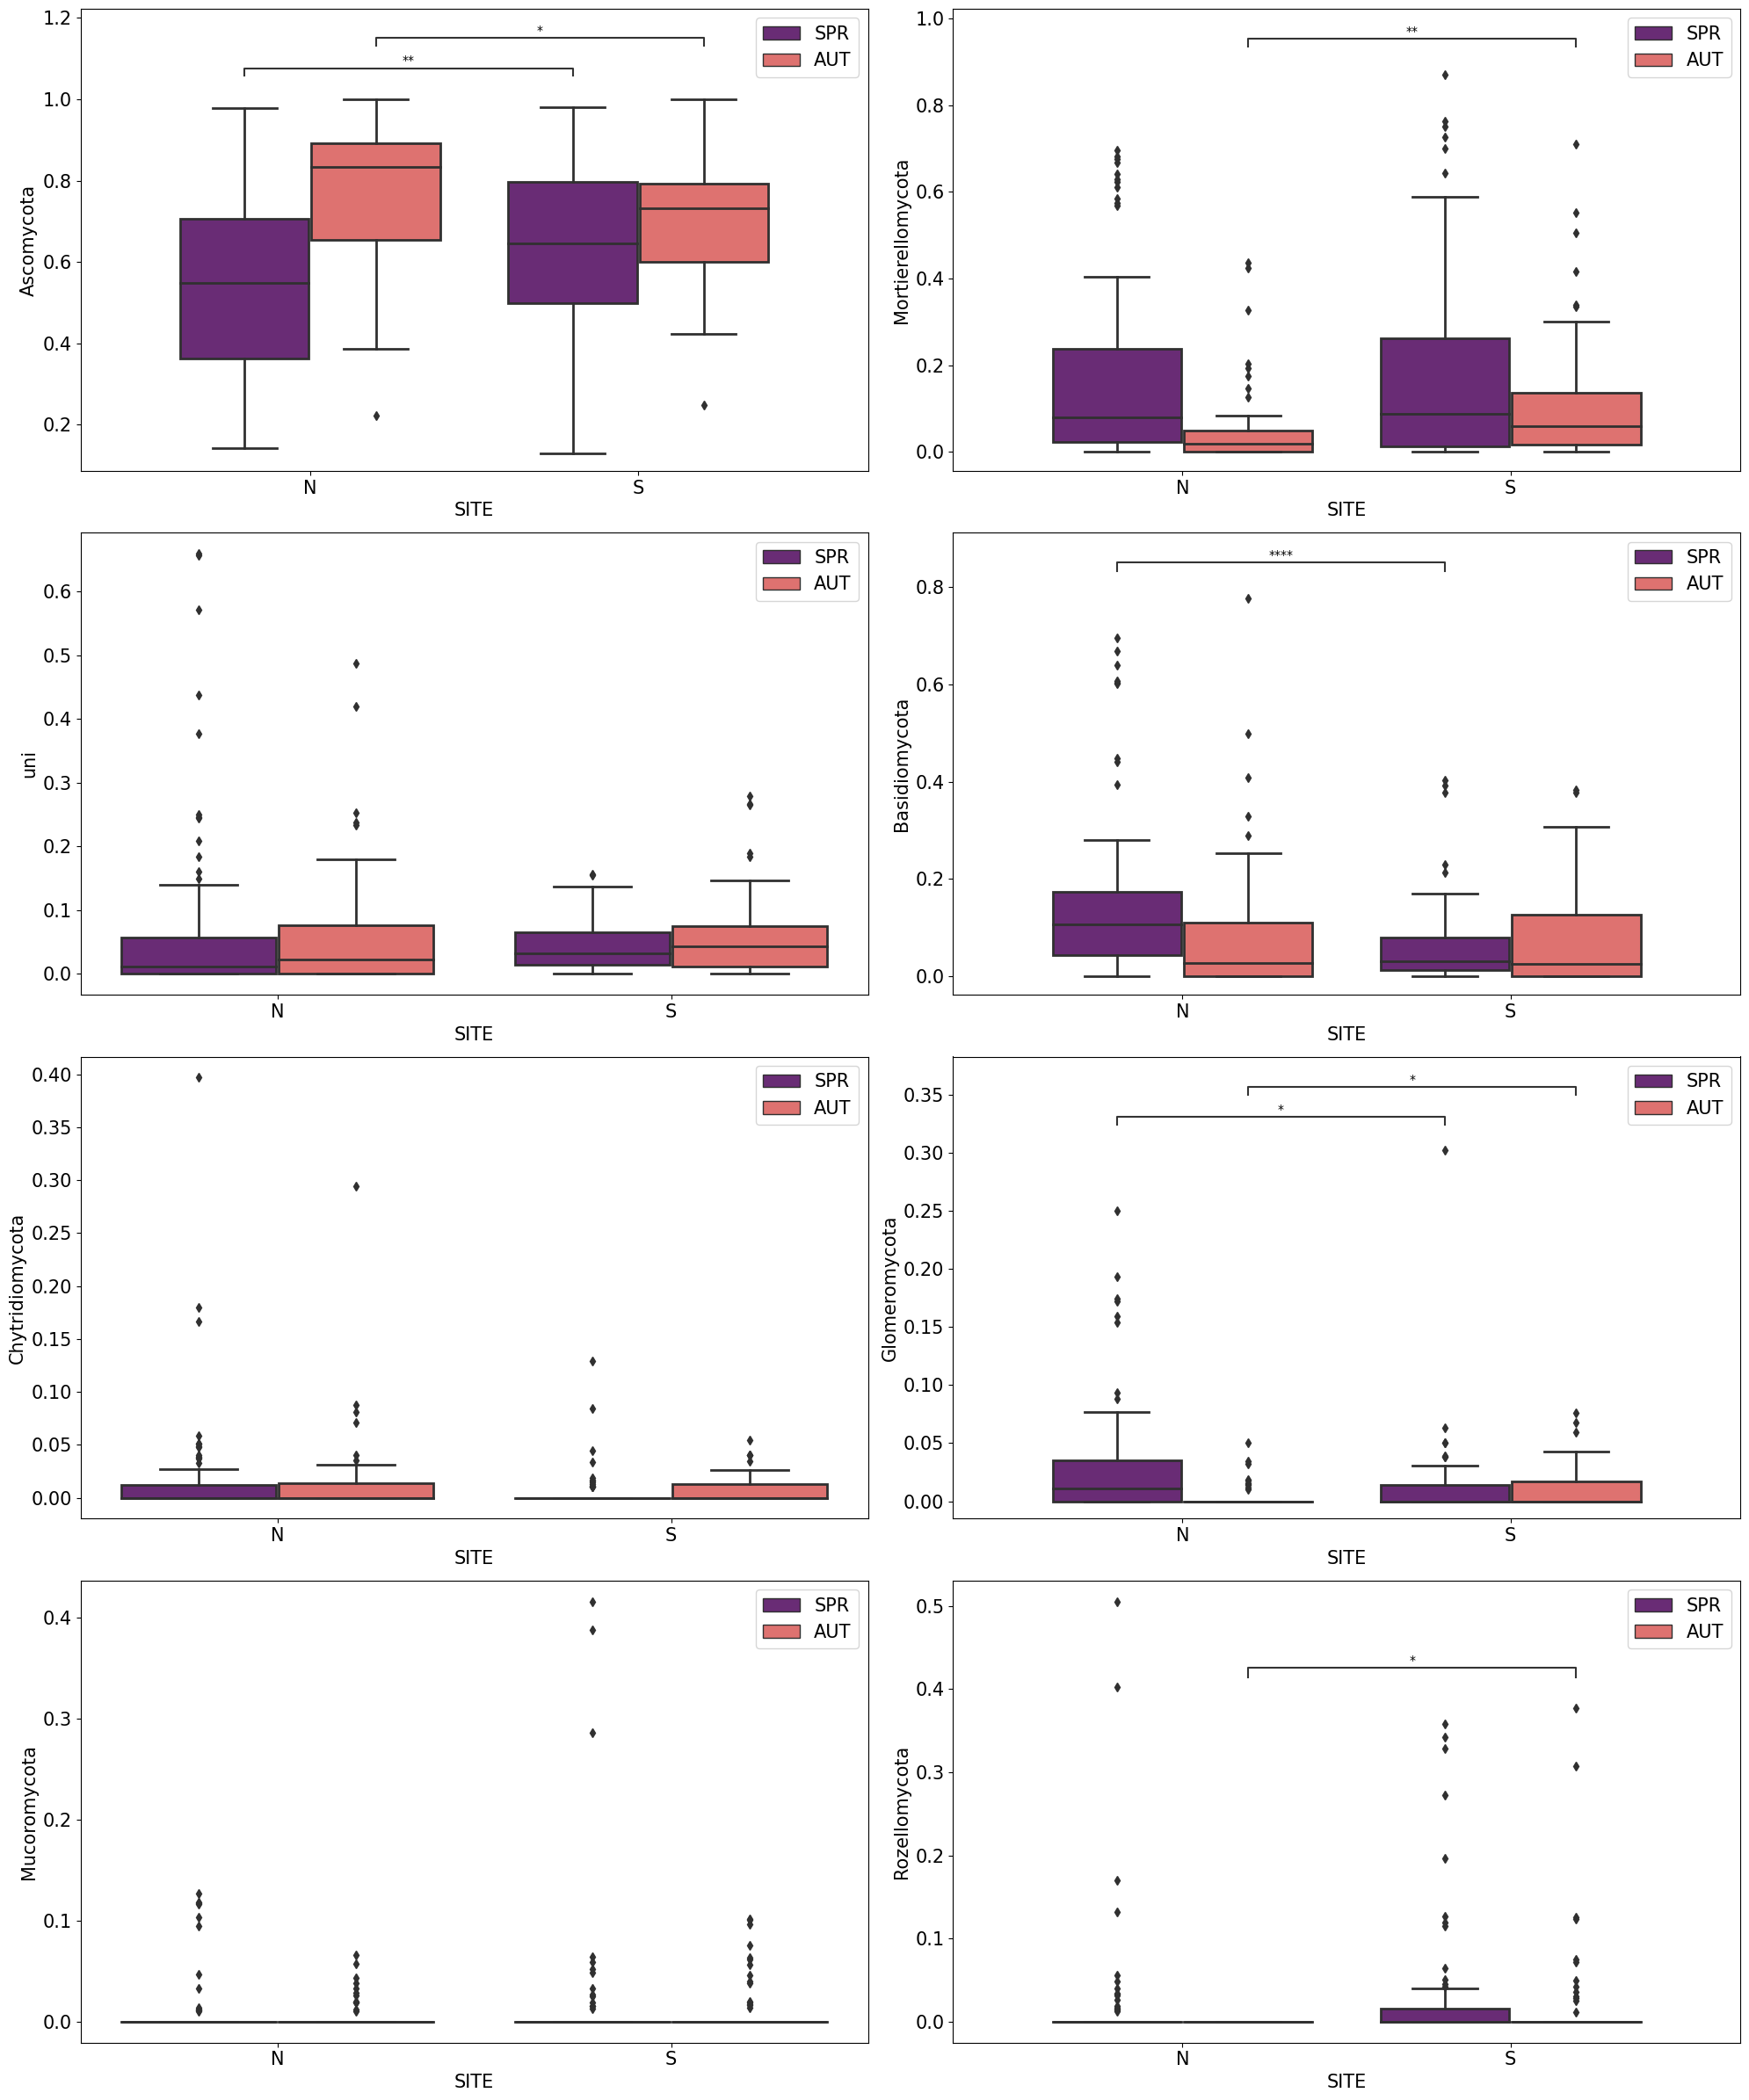

In [20]:
fig, axx = plt.subplots(4, 2, figsize=(2*10, 4*6), tight_layout=True)
axx = axx.reshape(-1)

pairs = [(("N", "SPR"),("S", "SPR")),
        (("N", "AUT"),("S", "AUT"))]

for ax, node in zip(axx, phyla_list):

    plotting_parameters = {
        'data':    df_ab,
        'x':       'SITE',
        'y':       node,
        'hue': "Season"
    }
    
    ax = sns.boxplot(**plotting_parameters, ax=ax, palette = "magma", linewidth=2)     

    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

    ax.legend(fontsize = 15)
    ax.set_xlabel("SITE", fontsize = 15)
    ax.set_ylabel(node, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)

plt.savefig("north_vs_south_phyla.pdf", bbox_inches = 'tight')

## ABIOTICS 

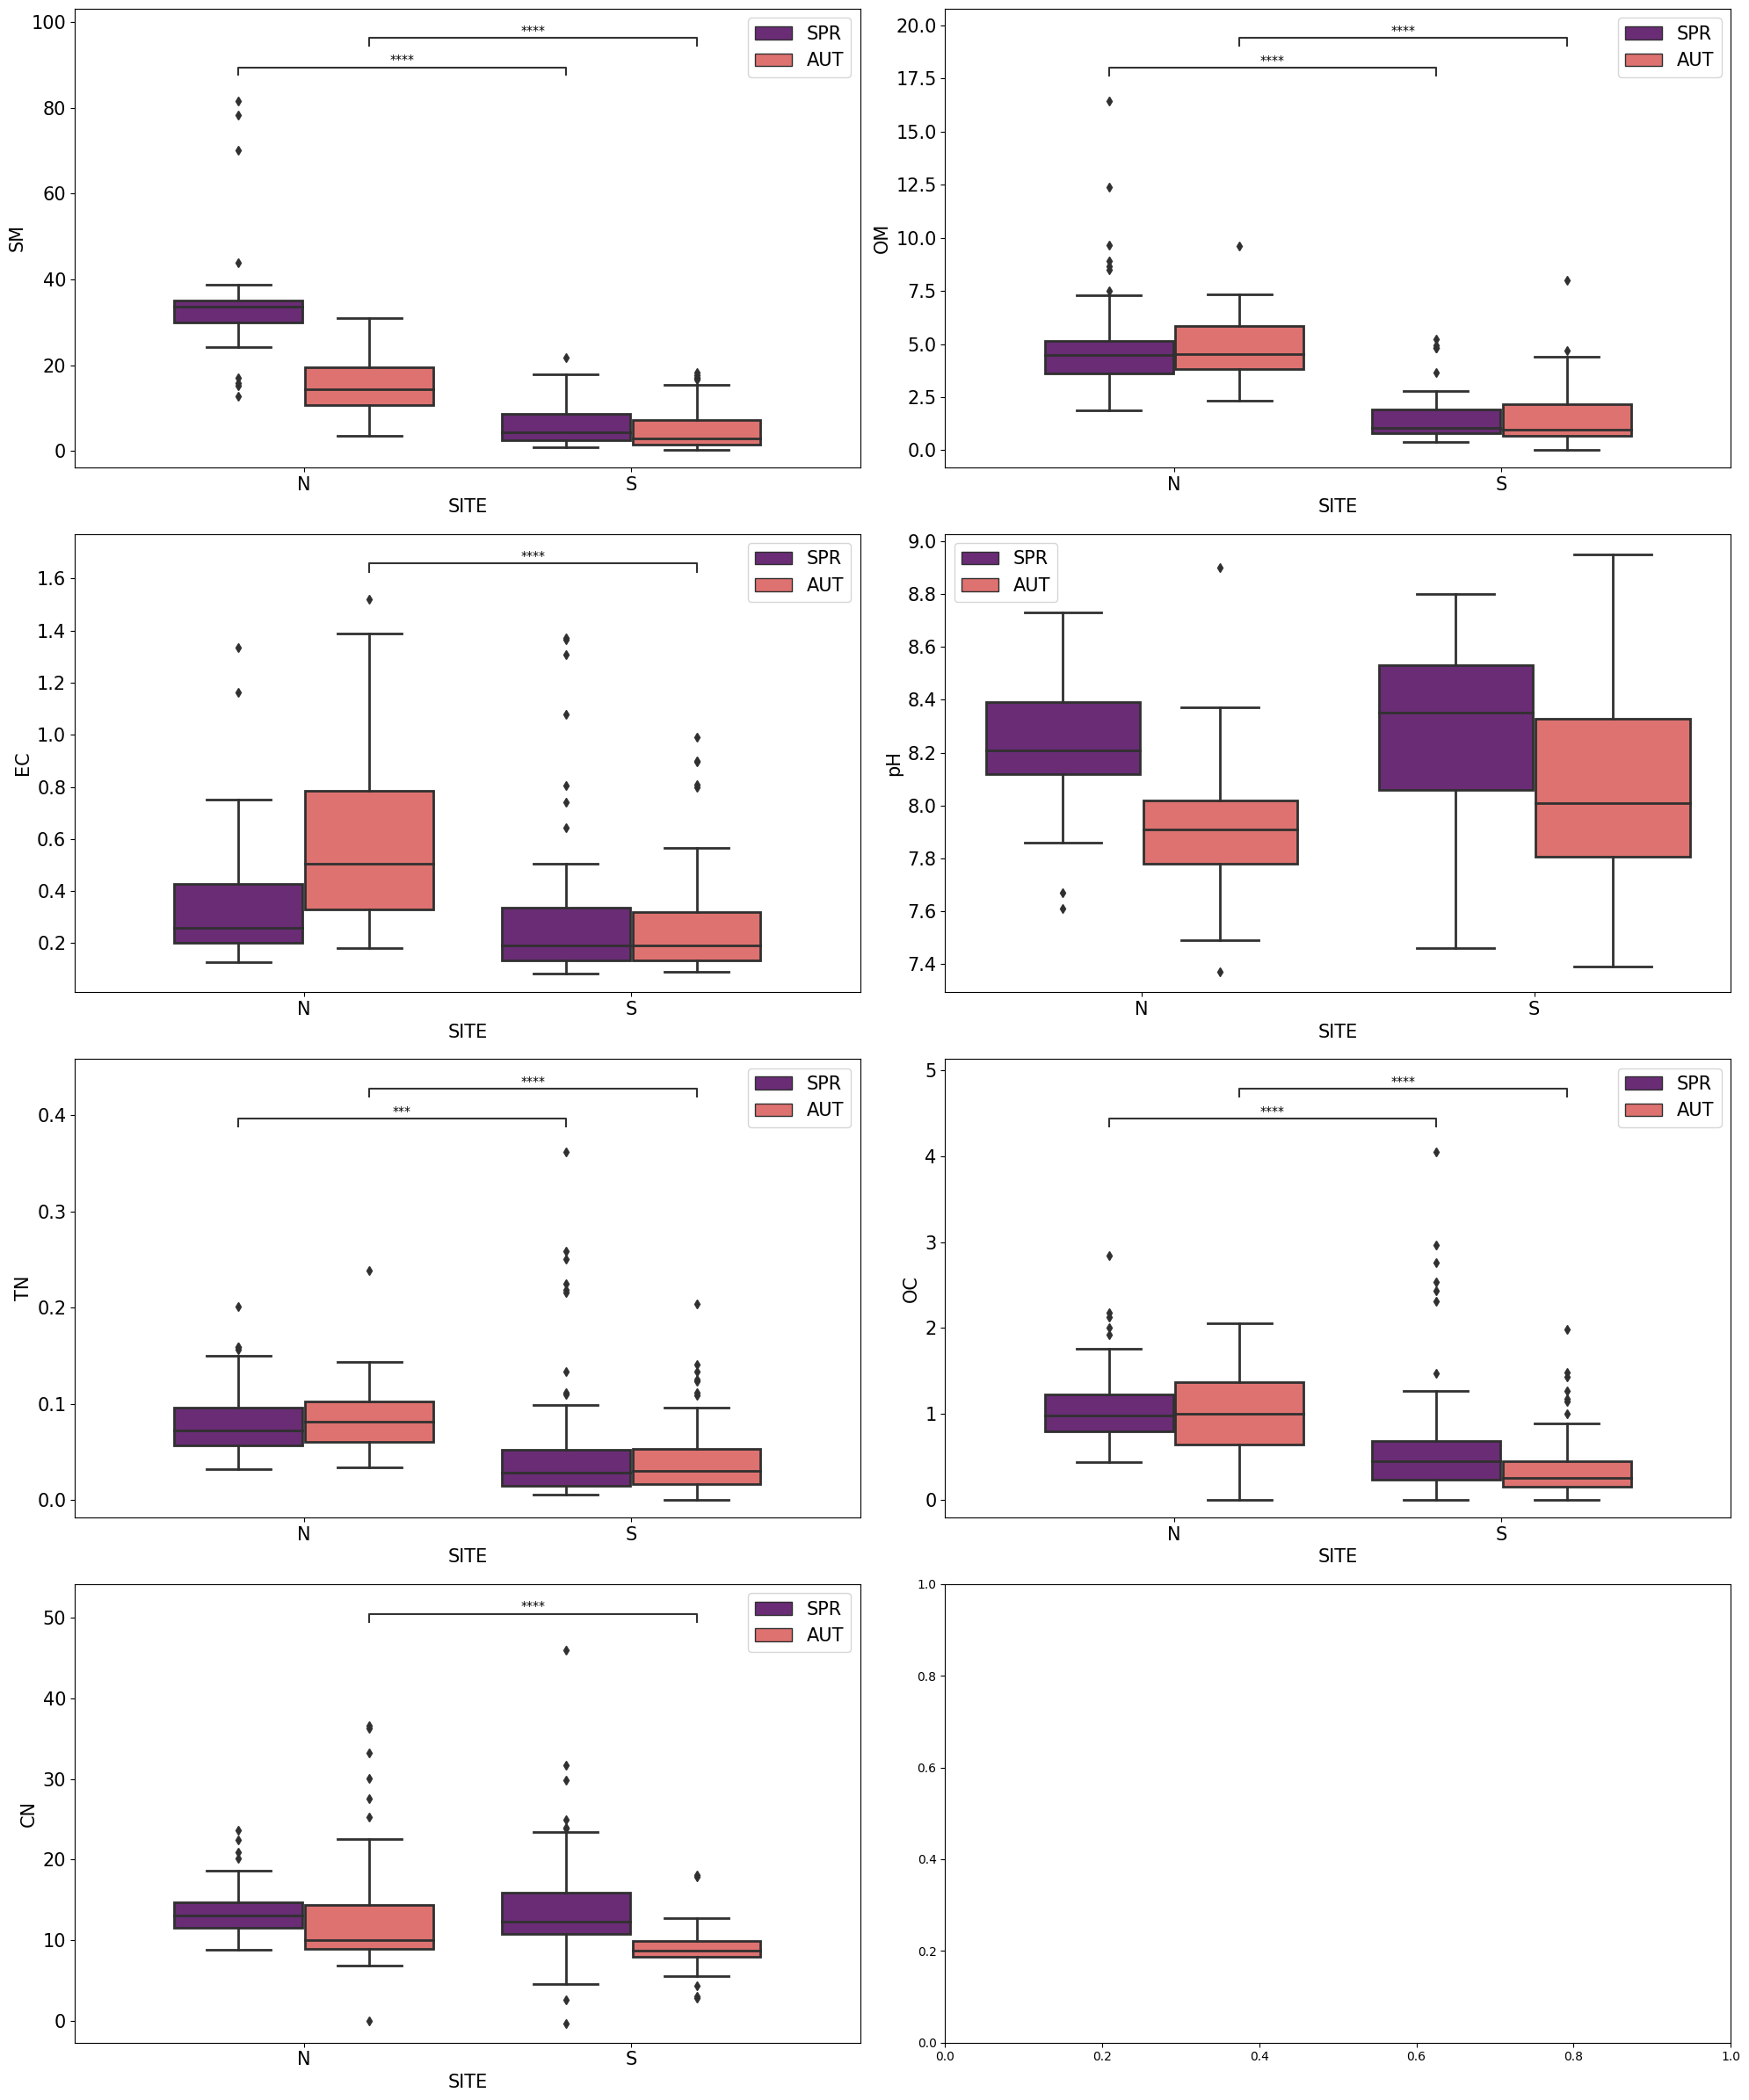

In [21]:
fig, axx = plt.subplots(4, 2, figsize=(2*10, 4*6), tight_layout=True)
axx = axx.reshape(-1)

pairs = [(("N", "SPR"),("S", "SPR")),
        (("N", "AUT"),("S", "AUT"))]

abiotic_list = ["SM", "OM", "EC", "pH", 'TN', 'OC', 'CN']

df_ab = df_ab.rename(columns={"S.M": "SM", "EC-(ds/m)": "EC", "TN-(%)" : "TN", "OC-(%)" : "OC", "C:N" : "CN"})
df_ab_mod = df_ab_mod.rename(columns={"S.M": "SM", "EC-(ds/m)": "EC", "TN-(%)" : "TN", "OC-(%)" : "OC", "C:N" : "CN"})

for ax, node in zip(axx, abiotic_list):

    plotting_parameters = {
        'data':    df_ab,
        'x':       'SITE',
        'y':       node,
        'hue': "Season"
    }
    
    ax = sns.boxplot(**plotting_parameters, ax=ax, palette = "magma", linewidth=2)    

    plotting_parameters = {
        'data':    df_ab_mod,
        'x':       'SITE',
        'y':       node,
        'hue': "Season"
    } 

    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

    ax.legend(fontsize = 15)
    ax.set_xlabel("SITE", fontsize = 15)
    ax.set_ylabel(node, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)

plt.savefig("north_vs_south_abiotics.pdf", bbox_inches = 'tight')

## RICHNESS/SHANNON INDEX 

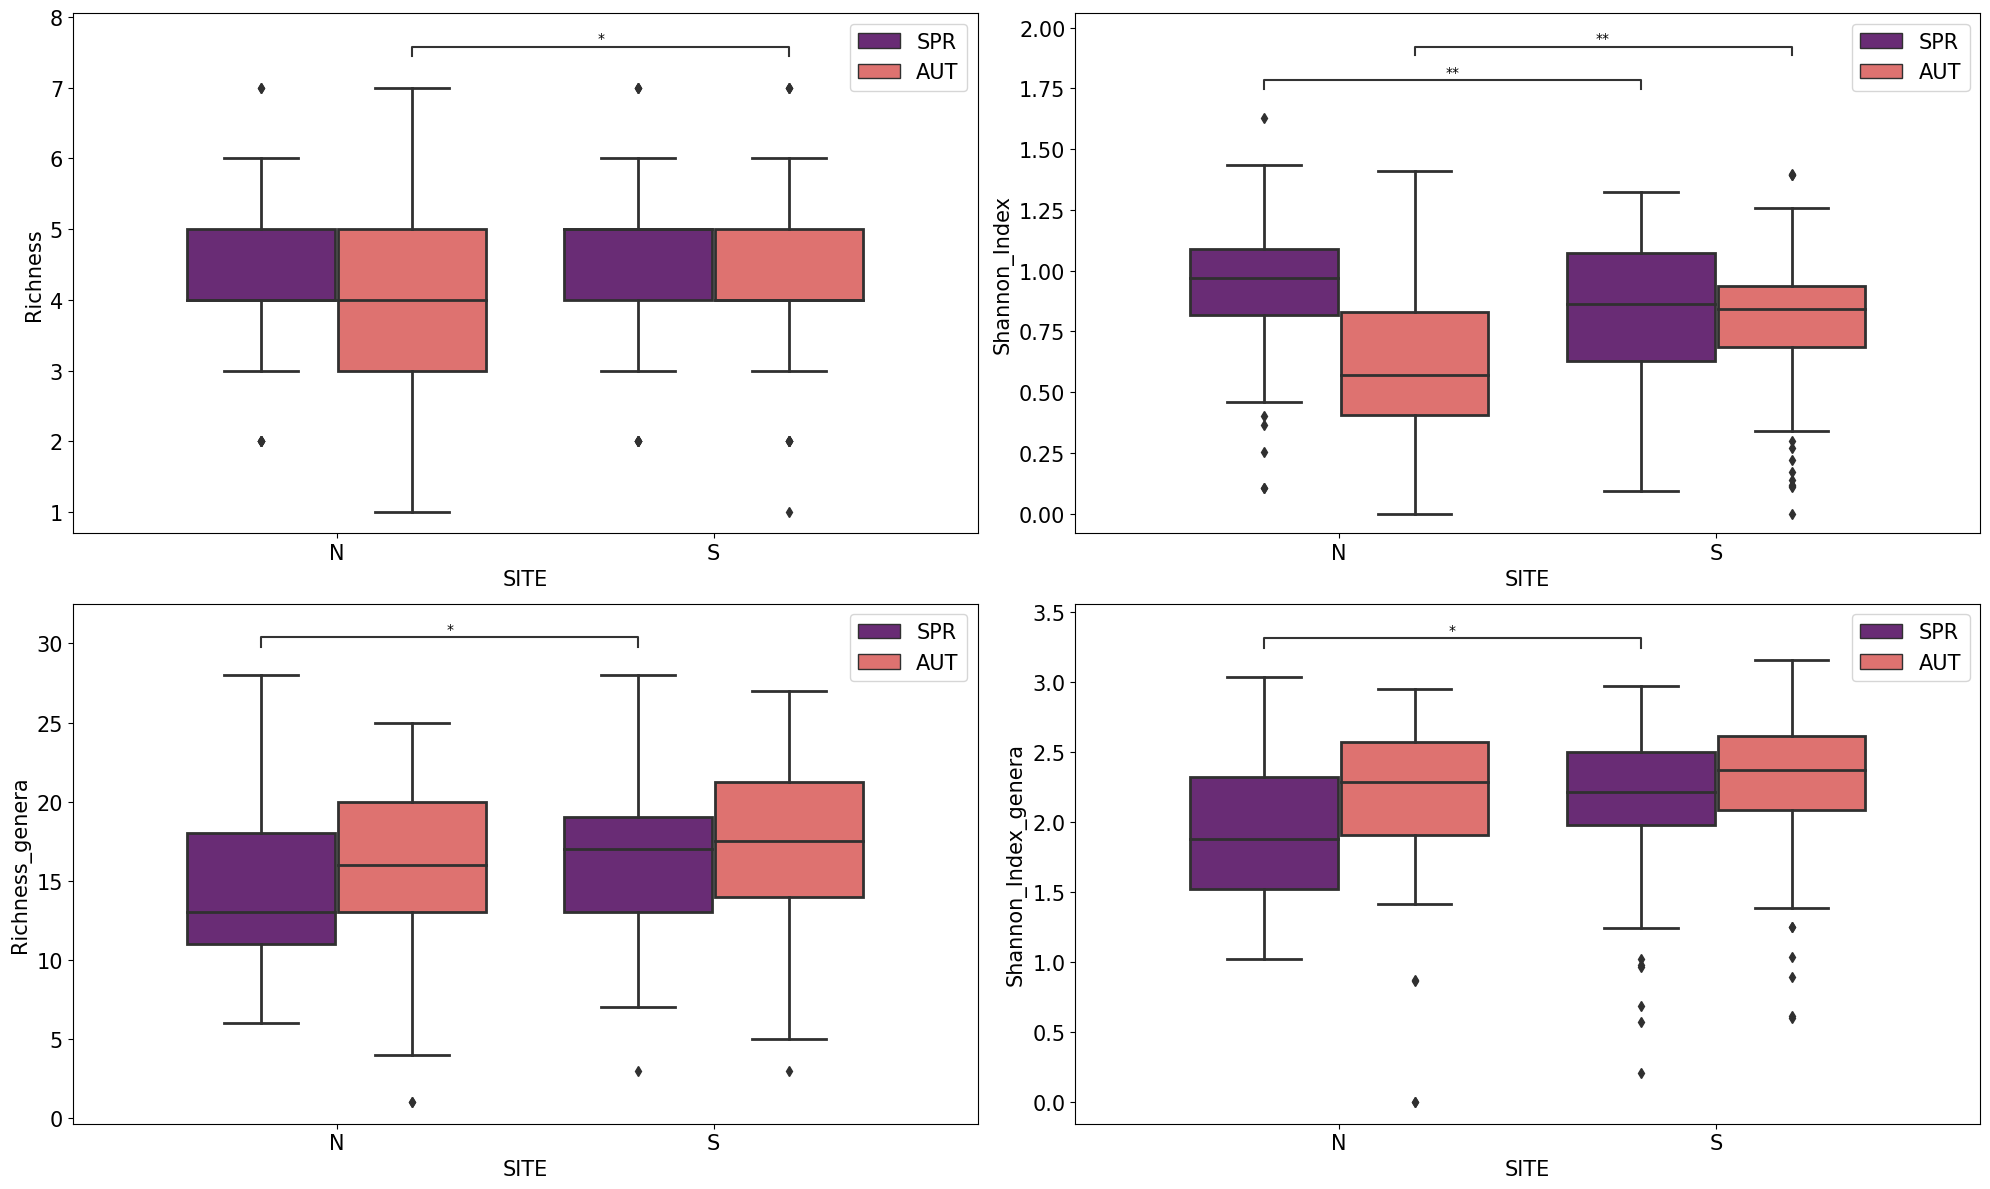

In [22]:
palette = {"SPR": "#a9f971", "AUT": "#650021"}

fig, axx = plt.subplots(2, 2, figsize=(2*10, 2*6), tight_layout=True)
axx = axx.reshape(-1)

pairs = [(("N", "SPR"),("S", "SPR")),
        (("N", "AUT"),("S", "AUT"))]

for ax, node in zip(axx, ["Richness", "Shannon_Index", "Richness_genera", "Shannon_Index_genera"]):

    if node == "Richness" or node == "Shannon_Index":
        plotting_parameters = {
            'data':    df_ab_mod,
            'x':       'SITE',
            'y':       node,
            'hue': "Season"
        }
    else:
        plotting_parameters = {
            'data':    df_genera,
            'x':       'SITE',
            'y':       node,
            'hue': "Season"
        }    
    ax = sns.boxplot(**plotting_parameters, ax=ax, palette = "magma", linewidth=2)     

    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

    ax.legend(fontsize = 15)
    ax.set_xlabel("SITE", fontsize = 15)
    ax.set_ylabel(node, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)

plt.savefig("pictures_paper/north_south_richness.pdf", bbox_inches = 'tight')
 

# ABIOTIC BOXPLOT (STRATIFICATION BY TREATMENT)

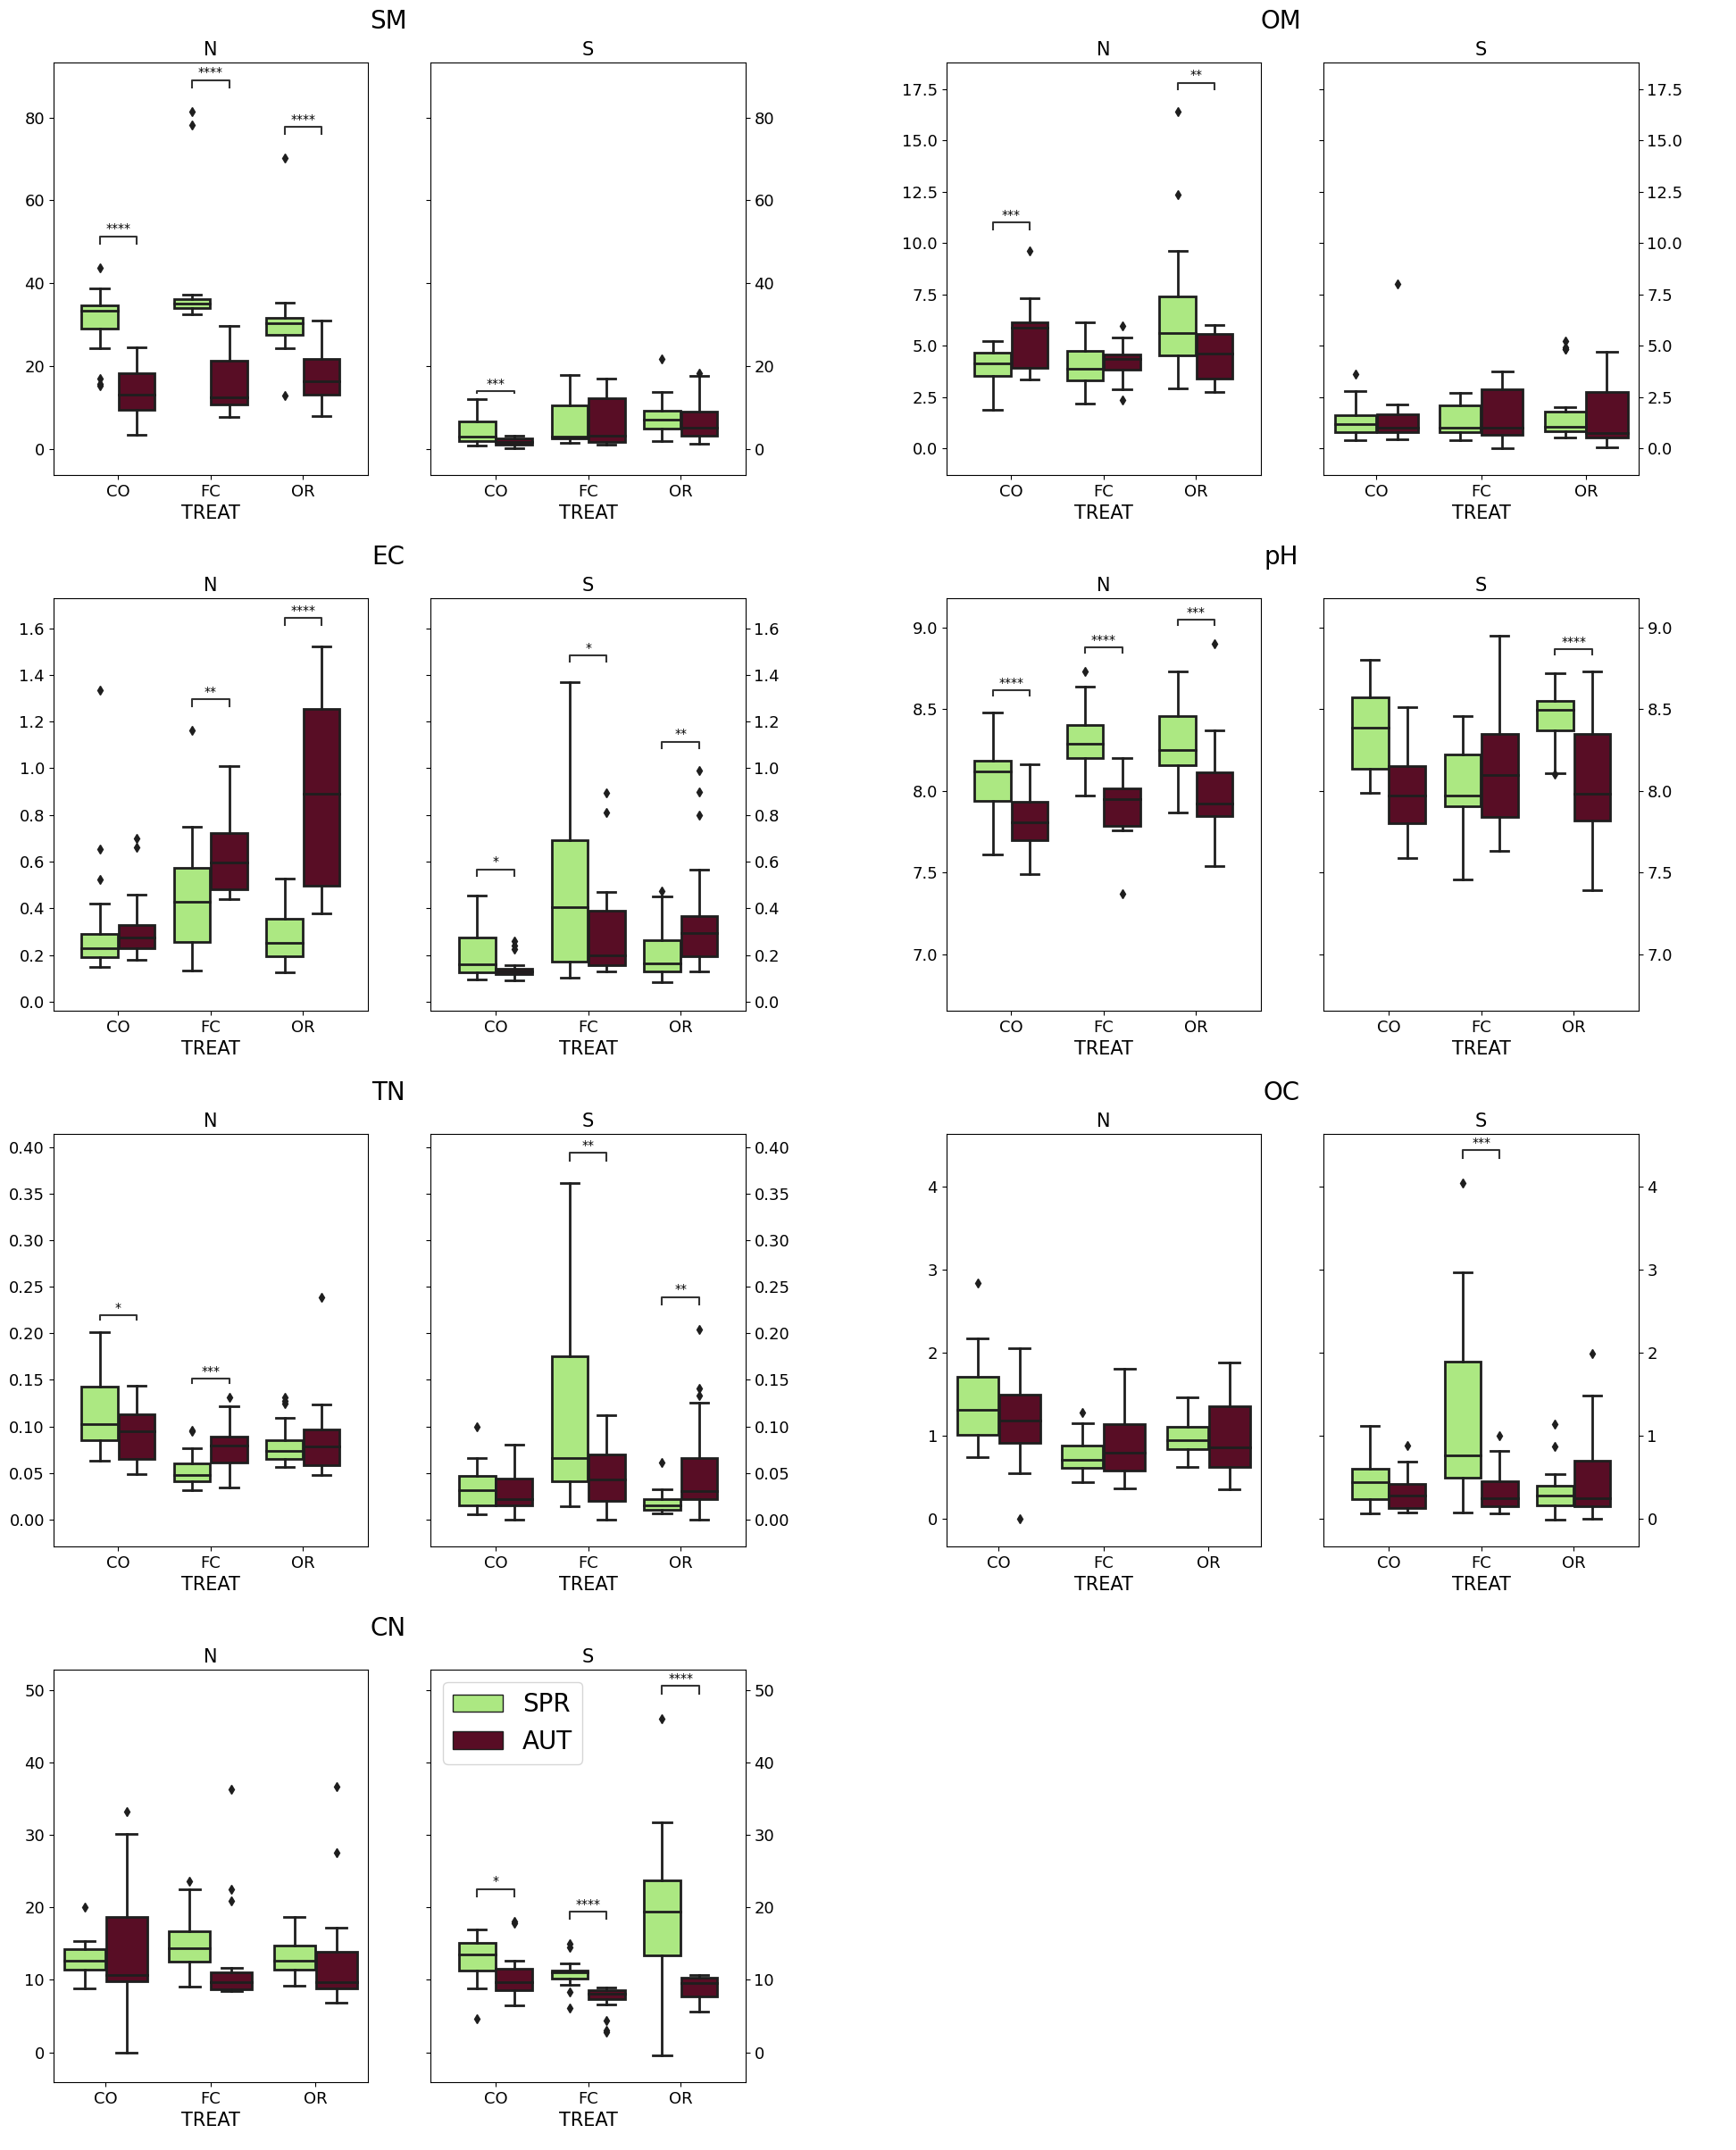

In [24]:
fig = plt.figure(figsize = (2*10, 4*6), layout = 'none')

subfigs = fig.subfigures(4, 2)

palette = {"SPR": "#a9f971", "AUT": "#650021"}

pairs = [(("CO", "SPR"),("CO", "AUT")),
        (("FC", "SPR"),("FC", "AUT")),
        (("OR", "SPR"),("OR", "AUT"))]

for outerind, subfig in enumerate(subfigs.flat[:-1]):
    subfig.suptitle(abiotic_list[outerind], fontsize = 20)
    axs = subfig.subplots(1, 2)

    val_max = np.max(df_ab[abiotic_list[outerind]]) + 0.145*(np.max(df_ab[abiotic_list[outerind]]) - np.min(df_ab[abiotic_list[outerind]]))
    val_min = np.min(df_ab[abiotic_list[outerind]]) - 0.08*np.max(df_ab[abiotic_list[outerind]])

    plotting_parameters = {
        'data':    df_ab[df_ab["SITE"]=="N"],
        'x':       'TREAT',
        'y':       abiotic_list[outerind],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[0], palette = palette, linewidth=2) 
    
    axs.flat[0].set_title('N', fontsize=15)
    axs.flat[0].get_legend().set_visible(False)
    axs.flat[0].set_ylabel(None)
    axs.flat[0].set_xlabel("TREAT", fontsize = 15)
    axs.flat[0].tick_params(axis = 'both', labelsize = 13)

    plotting_parameters = {
        'data':    df_ab_mod[df_ab_mod["SITE"]=="N"],
        'x':       'TREAT',
        'y':       abiotic_list[outerind],
        'hue': "Season"
    }

    annotator = Annotator(axs.flat[0], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

    axs.flat[0].set_ylim([val_min, val_max])

    plotting_parameters = {
        'data':    df_ab[df_ab["SITE"]=="S"],
        'x':       'TREAT',
        'y':       abiotic_list[outerind],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[1], palette = palette, linewidth=2)

    axs.flat[1].set_title('S', fontsize = 15)
    axs.flat[1].legend(fontsize = 20)
    if outerind < (len(abiotic_list)-1):
        axs.flat[1].get_legend().set_visible(False)
    axs.flat[1].set_ylabel(None)
    axs.flat[1].set_xlabel("TREAT", fontsize = 15)
    axs.flat[1].tick_params(axis = 'both', labelleft = False, labelright = True, right = True, labelsize = 13)

    plotting_parameters = {
        'data':    df_ab_mod[df_ab_mod["SITE"]=="S"],
        'x':       'TREAT',
        'y':       abiotic_list[outerind],
        'hue': "Season"
    }

    annotator = Annotator(axs.flat[1], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose=0)
    annotator.apply_and_annotate()

    axs.flat[1].set_ylim([val_min, val_max])

#fig.savefig('pictures_paper/abiotic_boxplot_with_sites.pdf', bbox_inches = 'tight')

# PHYLA ABUNDANCES BOXPLOT (STRATIFICATION BY TREATMENT)

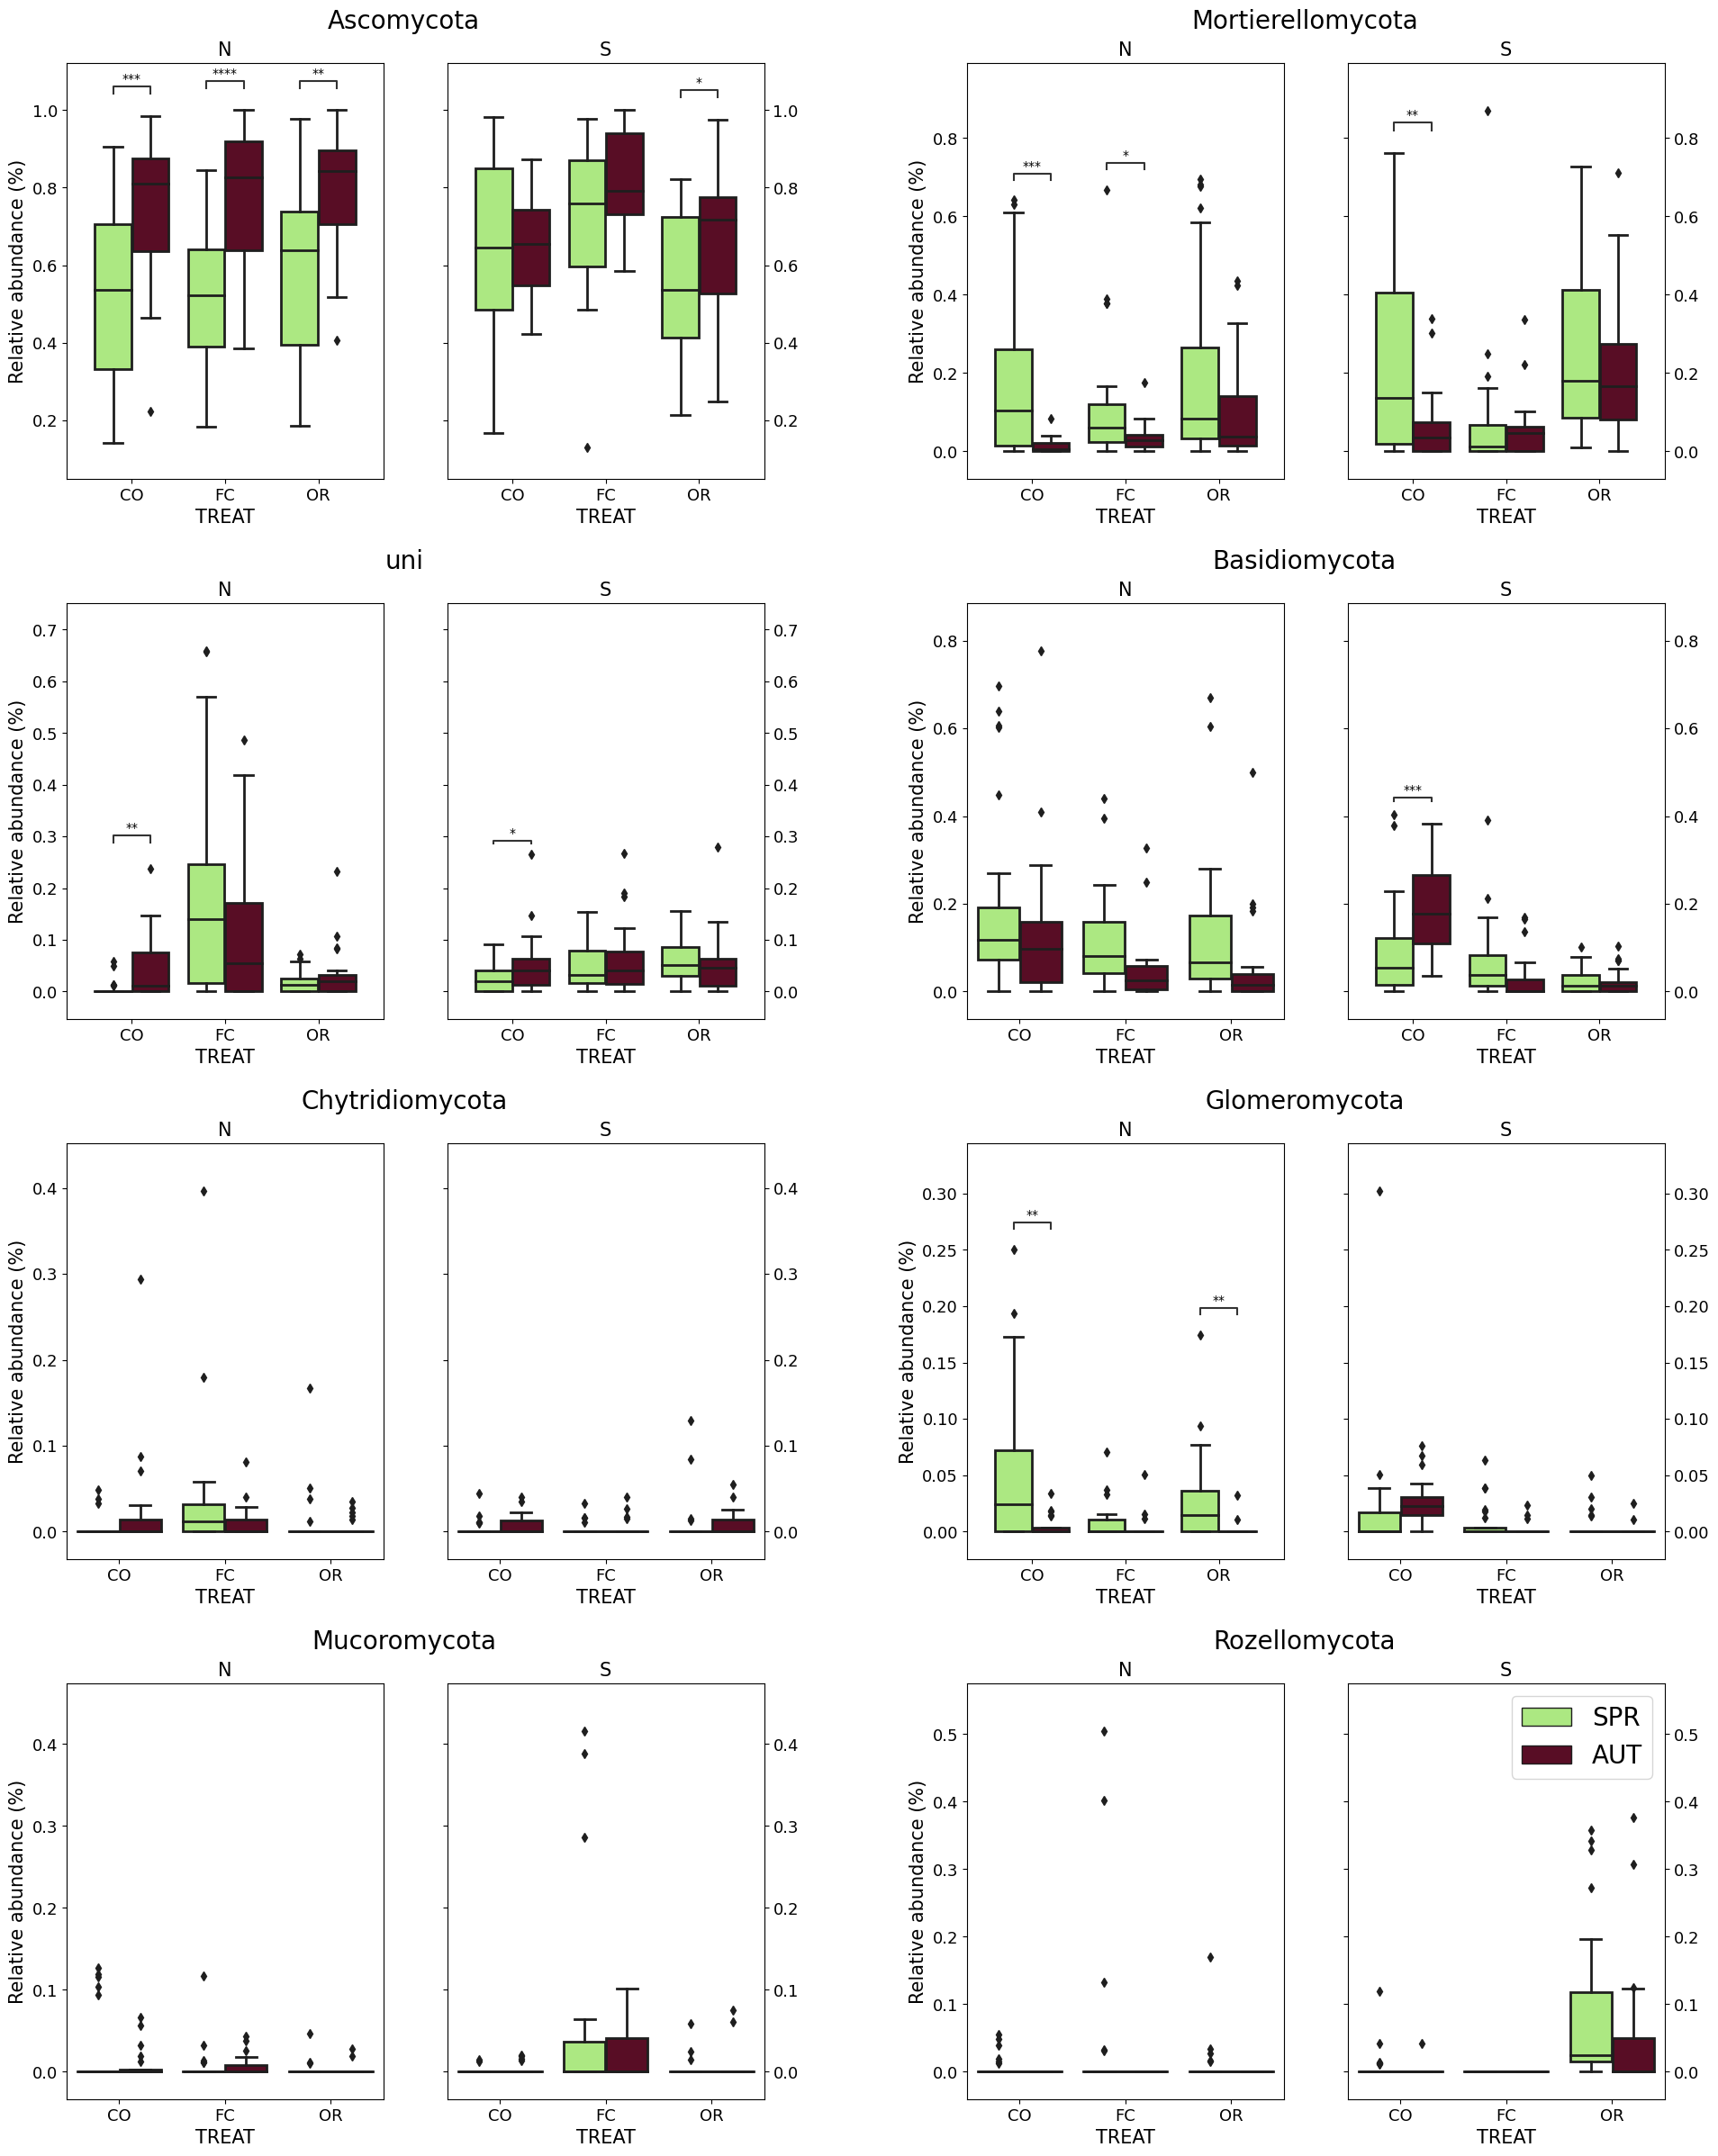

In [25]:
fig = plt.figure(figsize = (2*10, 4*6), layout = 'none')

palette = {"SPR": "#a9f971", "AUT": "#650021"}

subfigs = fig.subfigures(4, 2)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(phyla_list[outerind], fontsize = 20)
    axs = subfig.subplots(1, 2)

    val_max = np.max(df_ab[phyla_list[outerind]]) + 0.14*(np.max(df_ab[phyla_list[outerind]]) - np.min(df_ab[phyla_list[outerind]]))
    val_min = np.min(df_ab[phyla_list[outerind]]) - 0.08*np.max(df_ab[phyla_list[outerind]])

    plotting_parameters = {
        'data':    df_ab[df_ab["SITE"]=="N"],
        'x':       'TREAT',
        'y':       phyla_list[outerind],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[0], palette = palette, linewidth=2) 
    axs.flat[0].set_title('N', fontsize=15)

    axs.flat[0].get_legend().set_visible(False)
    axs.flat[0].set_ylabel("Relative abundance (%)", fontsize = 15)
    axs.flat[0].set_xlabel("TREAT", fontsize = 15)
    axs.flat[0].tick_params(axis = 'both', labelsize = 13)

    annotator = Annotator(axs.flat[0], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose = 0)
    annotator.apply_and_annotate()

    axs.flat[0].set_ylim([val_min, val_max])

    plotting_parameters = {
        'data':    df_ab[df_ab["SITE"]=="S"],
        'x':       'TREAT',
        'y':       phyla_list[outerind],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[1], palette = palette, linewidth=2) 

    axs.flat[1].set_title('S', fontsize = 15)
    axs.flat[1].legend(fontsize = 20)
    if outerind < (len(phyla_list)-1):
        axs.flat[1].get_legend().set_visible(False)
    axs.flat[1].set_ylabel(None)
    axs.flat[1].set_xlabel("TREAT", fontsize = 15)
    axs.flat[1].tick_params(axis = 'both', labelleft = False, labelright = True, right = True, labelsize = 13)

    annotator = Annotator(axs.flat[1], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose = 0)
    annotator.apply_and_annotate()

    axs.flat[1].set_ylim([val_min, val_max])

#fig.savefig("pictures_paper/phyla_boxplot_with_sites.pdf", bbox_inches = 'tight')

# PHYLA/SHANNON INDEX BOXPLOT (STRATIFICATION BY TREATMENT)

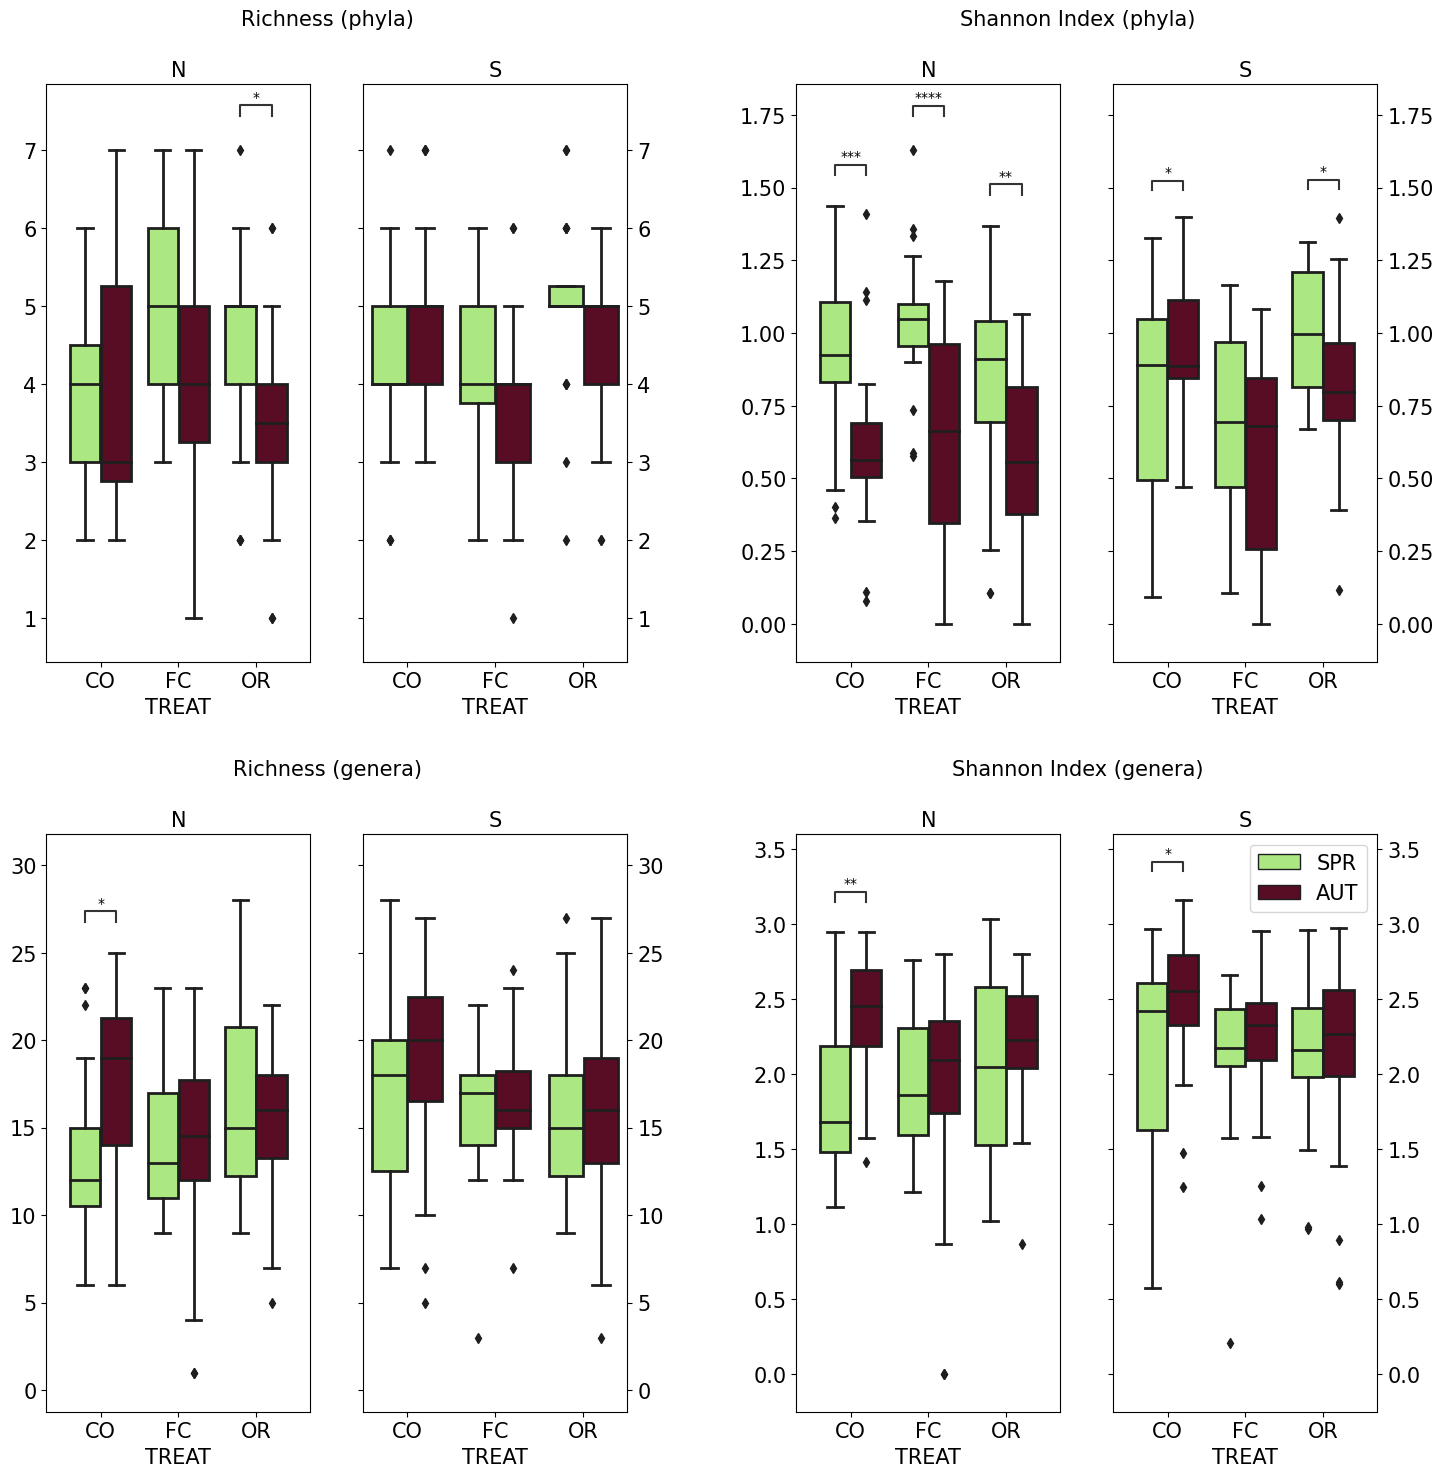

In [26]:
fig = plt.figure(figsize = (15, 15), layout = 'none')

subfigs = fig.subfigures(2, 2)

palette = {"SPR": "#a9f971", "AUT": "#650021"}

pairs = [(("CO", "SPR"),("CO", "AUT")),
        (("FC", "SPR"),("FC", "AUT")),
        (("OR", "SPR"),("OR", "AUT"))]

data_to_plot = [[df_ab_mod[df_ab_mod["SITE"]=="N"], df_ab_mod[df_ab_mod["SITE"]=="S"], "Richness"],
                [df_ab_mod[df_ab_mod["SITE"]=="N"], df_ab_mod[df_ab_mod["SITE"]=="S"], "Shannon_Index"],
                [df_genera[df_genera["SITE"]=="N"], df_genera[df_genera["SITE"]=="S"], "Richness_genera"],
                [df_genera[df_genera["SITE"]=="N"], df_genera[df_genera["SITE"]=="S"], "Shannon_Index_genera"]
                ]

community_idx = ["Richness (phyla)",
                 "Shannon Index (phyla)",
                 "Richness (genera)",
                 "Shannon Index (genera)"
                 ]

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(community_idx[outerind], fontsize = 15)
    axs = subfig.subplots(1, 2)

    if outerind < 2:
        val_max = np.max(df_ab_mod[data_to_plot[outerind][2]]) + 0.14*(np.max(df_ab_mod[data_to_plot[outerind][2]]) - np.min(df_ab_mod[data_to_plot[outerind][2]]))
        val_min = np.min(df_ab_mod[data_to_plot[outerind][2]]) - 0.08*np.max(df_ab_mod[data_to_plot[outerind][2]])
    else:
        val_max = np.max(df_genera[data_to_plot[outerind][2]]) + 0.14*(np.max(df_genera[data_to_plot[outerind][2]]) - np.min(df_genera[data_to_plot[outerind][2]]))
        val_min = np.min(df_genera[data_to_plot[outerind][2]]) - 0.08*np.max(df_genera[data_to_plot[outerind][2]])

    plotting_parameters = {
        'data':    data_to_plot[outerind][0],
        'x':       'TREAT',
        'y':       data_to_plot[outerind][2],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[0], palette = palette, linewidth=2) 
    
    axs.flat[0].set_title('N', fontsize=15)
    axs.flat[0].get_legend().set_visible(False)
    axs.flat[0].set_ylabel(None)
    axs.flat[0].set_xlabel("TREAT", fontsize = 15)
    axs.flat[0].tick_params(axis = 'both', labelsize = 15)

    annotator = Annotator(axs.flat[0], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose = 0)
    annotator.apply_and_annotate()

    axs.flat[0].set_ylim([val_min, val_max])

    plotting_parameters = {
        'data':    data_to_plot[outerind][1],
        'x':       'TREAT',
        'y':       data_to_plot[outerind][2],
        'hue': "Season"
    }

    ax = sns.boxplot(**plotting_parameters, ax=axs.flat[1], palette = palette, linewidth=2)

    axs.flat[1].set_title('S', fontsize = 15)
    axs.flat[1].legend(fontsize = 15)
    if outerind < (len(community_idx)-1):
        axs.flat[1].get_legend().set_visible(False)
    axs.flat[1].set_ylabel(None)
    axs.flat[1].set_xlabel("TREAT", fontsize = 15)
    axs.flat[1].tick_params(axis = 'both', labelleft = False, labelright = True, right = True, labelsize = 15)

    annotator = Annotator(axs.flat[1], pairs, **plotting_parameters)
    annotator.configure(text_format='star', test='t-test_ind', hide_non_significant=True, verbose = 0)
    annotator.apply_and_annotate()

    axs.flat[1].set_ylim([val_min, val_max])
 
#fig.savefig("pictures_paper/richness_shannon_boxplot_with_site.pdf", bbox_inches = 'tight')

## TABLES (MEAN + ERROR)

In [27]:
means = df_ab_mod.groupby(["SITE", "Season", "TREAT"]).mean()
err = df_ab_mod.groupby(["SITE", "Season", "TREAT"]).sem()  

means.insert(2, "Shannon_Index_genera", df_genera.groupby(["SITE", "Season", "TREAT"]).mean()["Shannon_Index_genera"])
means.insert(2, "Richness_genera", df_genera.groupby(["SITE", "Season", "TREAT"]).mean()["Richness_genera"])
err.insert(2, "Shannon_Index_genera", df_genera.groupby(["SITE", "Season", "TREAT"]).sem()["Shannon_Index_genera"])
err.insert(2, "Richness_genera", df_genera.groupby(["SITE", "Season", "TREAT"]).sem()["Richness_genera"])

In [28]:
means.replace(0.00, 0.01, inplace = True)
err.replace(0.00, 0.01, inplace = True)

In [29]:
# write a table

table = means.combine(err, lambda x, y: np.array([f"{x[i]:.2f} $\pm$ {y[i]:.2f}" for i in range(12)]))


In [30]:
## perform duncan test and annotate the table

nodes = ['SM',
 'OM',
 'EC',
 'pH',
 'TN',
 'OC',
 'CN',
 'Richness',
 'Shannon_Index',
 'Richness_genera',
 'Shannon_Index_genera',
 'Ascomycota',
 'Basidiomycota',
 'Chytridiomycota',
 'Glomeromycota',
 'Mortierellomycota',
 'Mucoromycota',
 'Rozellomycota',
 'uni']

parameter = "TREAT"       

for node in nodes:
    for site in ["N", "S"]:
        for season in ["SPR", "AUT"]:
            if node == "Richness_genera" or node == "Shannon_Index_genera":
                df_site_season = df_genera[(df_genera["Season"] == season) & (df_genera["SITE"] == site)]
            else:    
                df_site_season = df_ab_mod[(df_ab_mod["Season"] == season) & (df_ab_mod["SITE"] == site)]
            result, anova_table = duncan_test(df_site_season, node, parameter)
            annot = annotate_duncan_test(result, means.loc[(site, season)][node])
            for i, treat in enumerate(["CO", "FC", "OR"]):
                table[node].loc[(site, season, treat)]  = table[node].loc[(site, season, treat)] + " " + annot[i]

C:\Users\edo13\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\edo13\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
c:\Users\edo13\Dropbox\microbiome\duncan_test.py:39: RuntimeWarning: invalid value encountered in scalar divide
  r = mean_diff / se_diff


In [31]:
## print table of abiotics in latex format (first 4 columns)

latex_table = table[abiotic_list[:4]].to_latex(escape=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
  &     &    &                  SM &                 OM &                 EC &                 pH \\
SITE & Season & TREAT &                     &                    &                    &                    \\
\midrule
N & AUT & CO &  13.51 $\pm$ 1.20 a &  5.45 $\pm$ 0.35 b &  0.32 $\pm$ 0.03 a &  7.81 $\pm$ 0.04 a \\
  &     & FC &   14.30 $\pm$ 1.71  &  3.99 $\pm$ 0.31 a &  0.63 $\pm$ 0.04 b &   7.91 $\pm$ 0.04  \\
  &     & OR &  17.61 $\pm$ 1.48 b &  4.48 $\pm$ 0.24 a &  0.89 $\pm$ 0.08 c &  8.00 $\pm$ 0.06 b \\
  & SPR & CO &  30.96 $\pm$ 1.29 a &  4.01 $\pm$ 0.17 a &  0.30 $\pm$ 0.05 a &  8.08 $\pm$ 0.04 a \\
  &     & FC &  38.23 $\pm$ 2.33 b &  4.12 $\pm$ 0.19 a &  0.44 $\pm$ 0.04 b &  8.31 $\pm$ 0.04 b \\
  &     & OR &  30.68 $\pm$ 1.73 a &  6.39 $\pm$ 0.57 b &  0.28 $\pm$ 0.02 a &  8.29 $\pm$ 0.04 b \\
S & AUT & CO &   1.66 $\pm$ 0.19 a &   1.42 $\pm$ 0.31  &  0.14 $\pm$ 0.01 a &   8.00 $\pm$ 0.05  \\
  &     & FC &   6.46 $\pm$ 1.19 b &   

C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\3031349606.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table[abiotic_list[:4]].to_latex(escape=False)


In [32]:
## print table of abiotics in latex format (last 3 columns)

latex_table = table[abiotic_list[4:]].to_latex(escape=False)
print(latex_table)

\begin{tabular}{llllll}
\toprule
  &     &    &                 TN &                 OC &                  CN \\
SITE & Season & TREAT &                    &                    &                     \\
\midrule
N & AUT & CO &   0.09 $\pm$ 0.01  &   1.19 $\pm$ 0.12  &   14.55 $\pm$ 1.80  \\
  &     & FC &   0.08 $\pm$ 0.01  &   0.90 $\pm$ 0.09  &   12.35 $\pm$ 1.70  \\
  &     & OR &   0.08 $\pm$ 0.01  &   0.99 $\pm$ 0.10  &   12.49 $\pm$ 1.51  \\
  & SPR & CO &  0.11 $\pm$ 0.01 c &  1.43 $\pm$ 0.09 c &  12.90 $\pm$ 0.41 a \\
  &     & FC &  0.05 $\pm$ 0.00 a &  0.77 $\pm$ 0.04 a &  14.86 $\pm$ 0.68 b \\
  &     & OR &  0.08 $\pm$ 0.00 b &  1.00 $\pm$ 0.04 b &  12.97 $\pm$ 0.42 a \\
S & AUT & CO &  0.03 $\pm$ 0.00 a &   0.31 $\pm$ 0.04  &    8.27 $\pm$ 1.09  \\
  &     & FC &   0.05 $\pm$ 0.01  &   0.35 $\pm$ 0.05  &    6.51 $\pm$ 0.62  \\
  &     & OR &  0.05 $\pm$ 0.01 b &   0.51 $\pm$ 0.11  &    7.22 $\pm$ 0.78  \\
  & SPR & CO &  0.03 $\pm$ 0.00 a &  0.41 $\pm$ 0.05 a &  11.77 $\pm$

C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\4189025674.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table[abiotic_list[4:]].to_latex(escape=False)


In [33]:
## print table of phyla abundances in latex format (first 4 columns)

latex_table = table[phyla_list[:4]].to_latex(escape=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
  &     &    &         Ascomycota &  Mortierellomycota &                uni &      Basidiomycota \\
SITE & Season & TREAT &                    &                    &                    &                    \\
\midrule
N & AUT & CO &   0.75 $\pm$ 0.04  &  0.01 $\pm$ 0.00 a &  0.04 $\pm$ 0.01 a &  0.15 $\pm$ 0.04 b \\
  &     & FC &   0.78 $\pm$ 0.04  &  0.04 $\pm$ 0.01 a &  0.11 $\pm$ 0.03 b &  0.06 $\pm$ 0.02 a \\
  &     & OR &   0.79 $\pm$ 0.04  &  0.10 $\pm$ 0.03 b &  0.04 $\pm$ 0.01 a &  0.06 $\pm$ 0.03 a \\
  & SPR & CO &   0.51 $\pm$ 0.04  &   0.20 $\pm$ 0.04  &  0.01 $\pm$ 0.00 a &   0.20 $\pm$ 0.04  \\
  &     & FC &   0.50 $\pm$ 0.04  &   0.11 $\pm$ 0.03  &  0.18 $\pm$ 0.04 b &   0.11 $\pm$ 0.02  \\
  &     & OR &   0.59 $\pm$ 0.05  &   0.21 $\pm$ 0.05  &  0.02 $\pm$ 0.00 a &   0.13 $\pm$ 0.03  \\
S & AUT & CO &  0.65 $\pm$ 0.03 a &  0.07 $\pm$ 0.02 a &   0.05 $\pm$ 0.01  &  0.19 $\pm$ 0.02 b \\
  &     & FC &  0.82 $\pm$ 0.03 b &  0.06 $\pm$ 

C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\199565666.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table[phyla_list[:4]].to_latex(escape=False)


In [34]:
## print table of phyla abundances in latex format (last 4 columns)

latex_table = table[phyla_list[4:]].to_latex(escape=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
  &     &    &    Chytridiomycota &      Glomeromycota &       Mucoromycota &      Rozellomycota \\
SITE & Season & TREAT &                    &                    &                    &                    \\
\midrule
N & AUT & CO &   0.03 $\pm$ 0.02  &   0.00 $\pm$ 0.00  &   0.01 $\pm$ 0.00  &   0.01 $\pm$ 0.01  \\
  &     & FC &   0.01 $\pm$ 0.01  &   0.00 $\pm$ 0.00  &   0.01 $\pm$ 0.00  &   0.01 $\pm$ 0.01  \\
  &     & OR &   0.01 $\pm$ 0.00  &   0.00 $\pm$ 0.00  &   0.00 $\pm$ 0.00  &   0.01 $\pm$ 0.01  \\
  & SPR & CO &  0.00 $\pm$ 0.00 a &  0.05 $\pm$ 0.01 b &  0.02 $\pm$ 0.01 b &   0.01 $\pm$ 0.00  \\
  &     & FC &  0.04 $\pm$ 0.02 b &  0.01 $\pm$ 0.00 a &   0.01 $\pm$ 0.00  &   0.04 $\pm$ 0.02  \\
  &     & OR &   0.01 $\pm$ 0.01  &   0.03 $\pm$ 0.01  &  0.00 $\pm$ 0.00 a &   0.01 $\pm$ 0.01  \\
S & AUT & CO &   0.01 $\pm$ 0.00  &  0.03 $\pm$ 0.00 b &  0.00 $\pm$ 0.00 a &  0.00 $\pm$ 0.00 a \\
  &     & FC &   0.00 $\pm$ 0.00  &  0.00 $\pm$ 

C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\2986419960.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table[phyla_list[4:]].to_latex(escape=False)


In [35]:
## print table of community indices in latex format

latex_table = table[["Richness", "Shannon_Index", "Richness_genera", "Shannon_Index_genera"]].to_latex(escape=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
  &     &    &           Richness &      Shannon_Index &     Richness_genera & Shannon_Index_genera \\
SITE & Season & TREAT &                    &                    &                     &                      \\
\midrule
N & AUT & CO &   3.75 $\pm$ 0.37  &   0.63 $\pm$ 0.07  &  17.10 $\pm$ 1.31 b &    2.35 $\pm$ 0.10 b \\
  &     & FC &   3.94 $\pm$ 0.42  &   0.62 $\pm$ 0.09  &  13.39 $\pm$ 1.45 a &    1.87 $\pm$ 0.19 a \\
  &     & OR &   3.50 $\pm$ 0.30  &   0.54 $\pm$ 0.07  &   15.59 $\pm$ 0.90  &     2.18 $\pm$ 0.10  \\
  & SPR & CO &  4.04 $\pm$ 0.24 a &   0.94 $\pm$ 0.05  &  13.15 $\pm$ 0.92 a &     1.85 $\pm$ 0.10  \\
  &     & FC &  4.78 $\pm$ 0.22 b &  1.04 $\pm$ 0.04 b &   14.11 $\pm$ 0.77  &     1.92 $\pm$ 0.09  \\
  &     & OR &   4.41 $\pm$ 0.25  &  0.85 $\pm$ 0.06 a &  16.46 $\pm$ 1.06 b &     2.05 $\pm$ 0.12  \\
S & AUT & CO &  4.87 $\pm$ 0.23 b &  0.95 $\pm$ 0.05 b &  18.96 $\pm$ 1.17 b &    2.48 $\pm$ 0.09 b \\
  &     & FC &  3.58 

C:\Users\edo13\AppData\Local\Temp\ipykernel_29756\2747997027.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table[["Richness", "Shannon_Index", "Richness_genera", "Shannon_Index_genera"]].to_latex(escape=False)
